In [1]:
data_path = 'Data/WindEnergy.csv'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.tsa.stattools as st
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
import Utils.functions as utils
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings("ignore")

# Load the dataset


Convert the dataset into a pandas dataframe. The column utc_timestamp will be the index of the dataframe I'm going to use.

In [3]:
df_completed = pd.read_csv(data_path, parse_dates=['utc_timestamp'], index_col=['utc_timestamp'],sep=',')
df_completed = df_completed.asfreq('d')
# looking the data set
df_completed.head()

wind_generation_actual  wind_capacity  temperature
utc_timestamp                                                                
2017-01-01 00:00:00+00:00                291760.0      37149.130       -2.117
2017-01-02 00:00:00+00:00                295097.0      37152.125       -1.154
2017-01-03 00:00:00+00:00                666170.0      37155.208       -0.239
2017-01-04 00:00:00+00:00                686581.0      37160.125        0.620
2017-01-05 00:00:00+00:00                261759.0      37163.542       -3.908

Looking more into the dataset we see that it has three different features:
* wind_generation_actual: power generated by the turbines in Germany on that day;
* temperature: mean temperature on that day
* wind_capacity: total amount of power generated through a time interval

### Check for null values

In [4]:
#Check if the data is ok, or if there are some None values
df_completed.info()

#checking null value 
df_completed.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2017-01-01 00:00:00+00:00 to 2019-12-30 00:00:00+00:00
Freq: D
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   wind_generation_actual  1094 non-null   float64
 1   wind_capacity           1094 non-null   float64
 2   temperature             1094 non-null   float64
dtypes: float64(3)
memory usage: 34.2 KB


wind_generation_actual    0
wind_capacity             0
temperature               0
dtype: int64

The dataframe is clean and without null values, there is no need to preprocessing to the data as it is right now. The next move is to capture some information about the individual features.

In [5]:
df_completed.describe().T.round(2)

count       mean        std       min        25%  \
wind_generation_actual  1094.0  305819.77  205728.86  16482.00  148552.75   
wind_capacity           1094.0   45066.02    4315.84  37149.13   41447.94   
temperature             1094.0      10.05       7.74     -9.36       3.58   

                              50%        75%        max  
wind_generation_actual  254332.50  412570.50  998899.00  
wind_capacity            46073.00   49203.00   50452.00  
temperature                 10.05      16.57      28.24

It's far easy to see that the wind_generation_actual is the column with the highest values, indeed the temperature is the lowest one.

## First Look on the Features

In this section we're going to analyze the single features in search of informations, patterns and characteristics of which the dataset is made of.

#### Wind_generation_actual

Text(0.5, 1.0, 'Wind generation through the years')

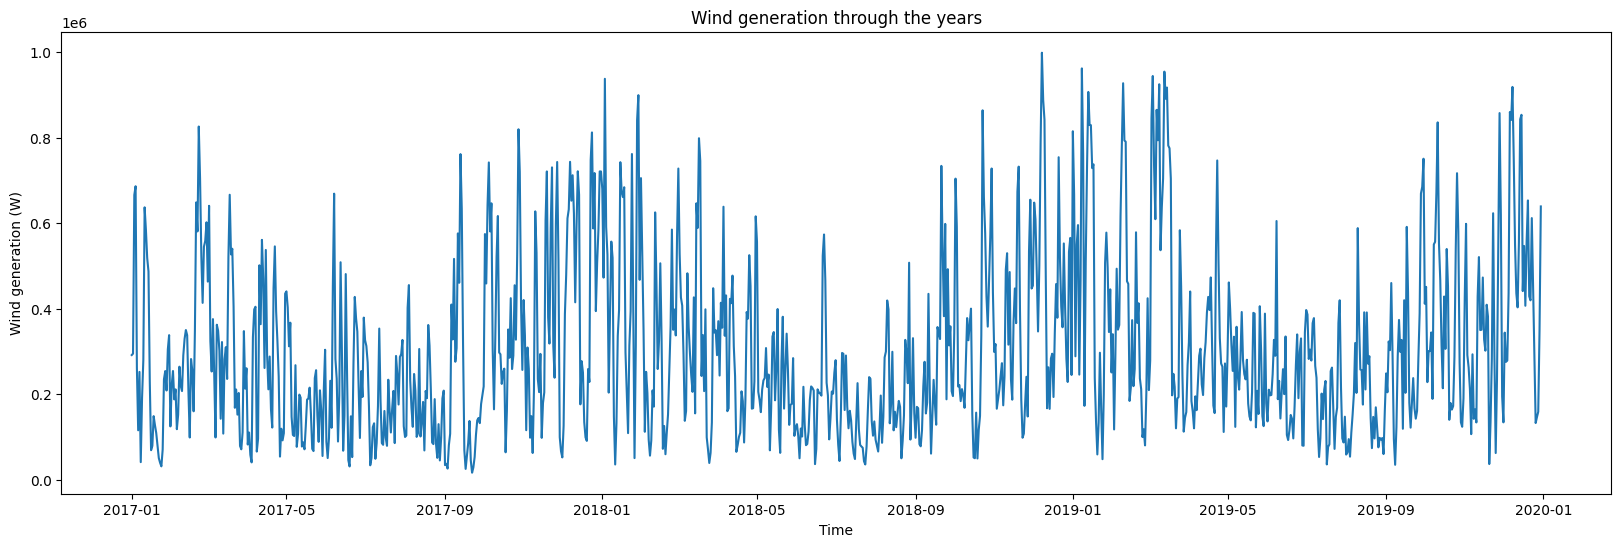

In [6]:
plt.figure(figsize=(20,6))
sns.lineplot(data=df_completed, x="utc_timestamp",y="wind_generation_actual")
plt.ylabel("Wind generation (W)")
plt.xlabel('Time')
plt.title("Wind generation through the years")

From here we can see that the summer season is the one with the lowest wind generation and the winter one is the one with the highest, the reason why is that is going to be responded. There is somewhat seasonality in the data which is visible from the recurring patterns and probably a cyclic component too.

#### Wind capacity

Text(0.5, 1.0, 'Wind capacity through the years')

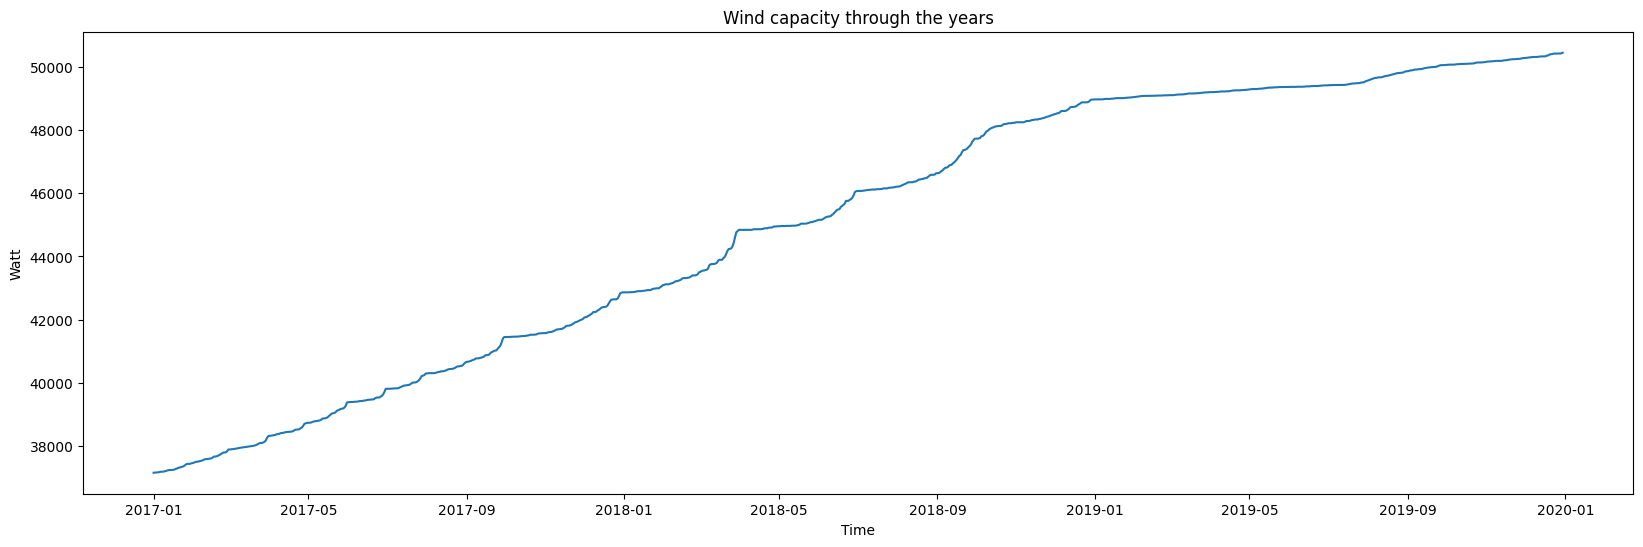

In [7]:
plt.figure(figsize=(20,6))
sns.lineplot(data=df_completed, x="utc_timestamp",y="wind_capacity")
plt.ylabel("Watt")
plt.xlabel('Time')
plt.title("Wind capacity through the years")

From the plot it's possible to see that there is a "wavy" recurring pattern which starts pretty slowly on 2017 but later on between the years 2018-2019 the "waves" are a bit longer and higher. One or more causes can be seen here https://windeurope.org/wp-content/uploads/files/about-wind/statistics/WindEurope-Annual-Statistics-2018.pdf. Summing up:
* Technological Advancements
* Decreasing Costs
* Public investements
* Economy of scale

#### Temperature

Text(0.5, 1.0, 'Temperature change through the years')

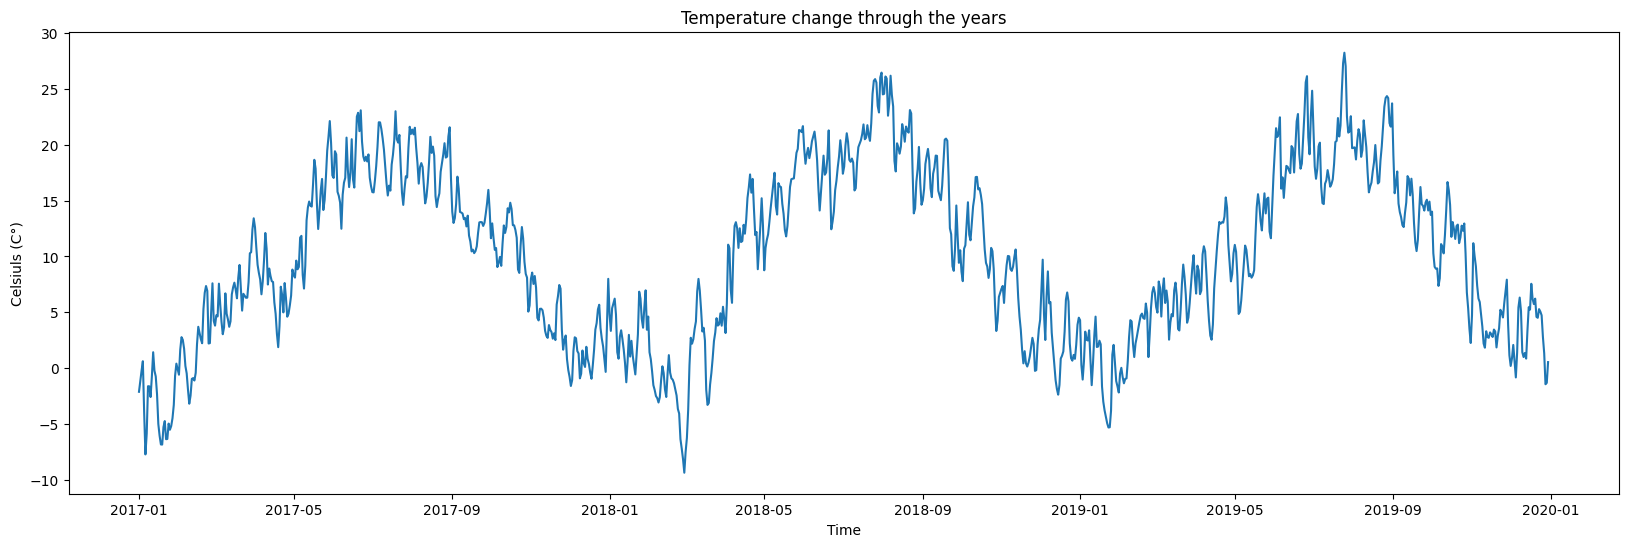

In [8]:
plt.figure(figsize=(20,6))
sns.lineplot(data=df_completed, x="utc_timestamp",y="temperature")
plt.ylabel("Celsiuls (C°)")
plt.xlabel('Time')
plt.title("Temperature change through the years")

The temperature shows a seasonal part recurring every year and that can be seen from the three "spikes" which starts pretty low then reach the highest on mid and then start decreasing. This is common for the temperatures because in the first few months there are the lowest temperatures then it follows the spring/summer part where it increases and lastly the autumn/winter where the temperatures drop. It's interesting to see that there is a big drop on march 2018, the reason why can be seen on this link https://www.dwd.de/EN/press/press_release/EN/2018/20180329_the_weather_in_germany_in_march_2018.pdf?__blob=publicationFile&v=2.

# Explainable Data Analysis

Before doing the part of the modeling and the cleaning, it's important to note some patterns of the data we have. In this part, I'm doing some explainatory data analyisis.

## Plots of features

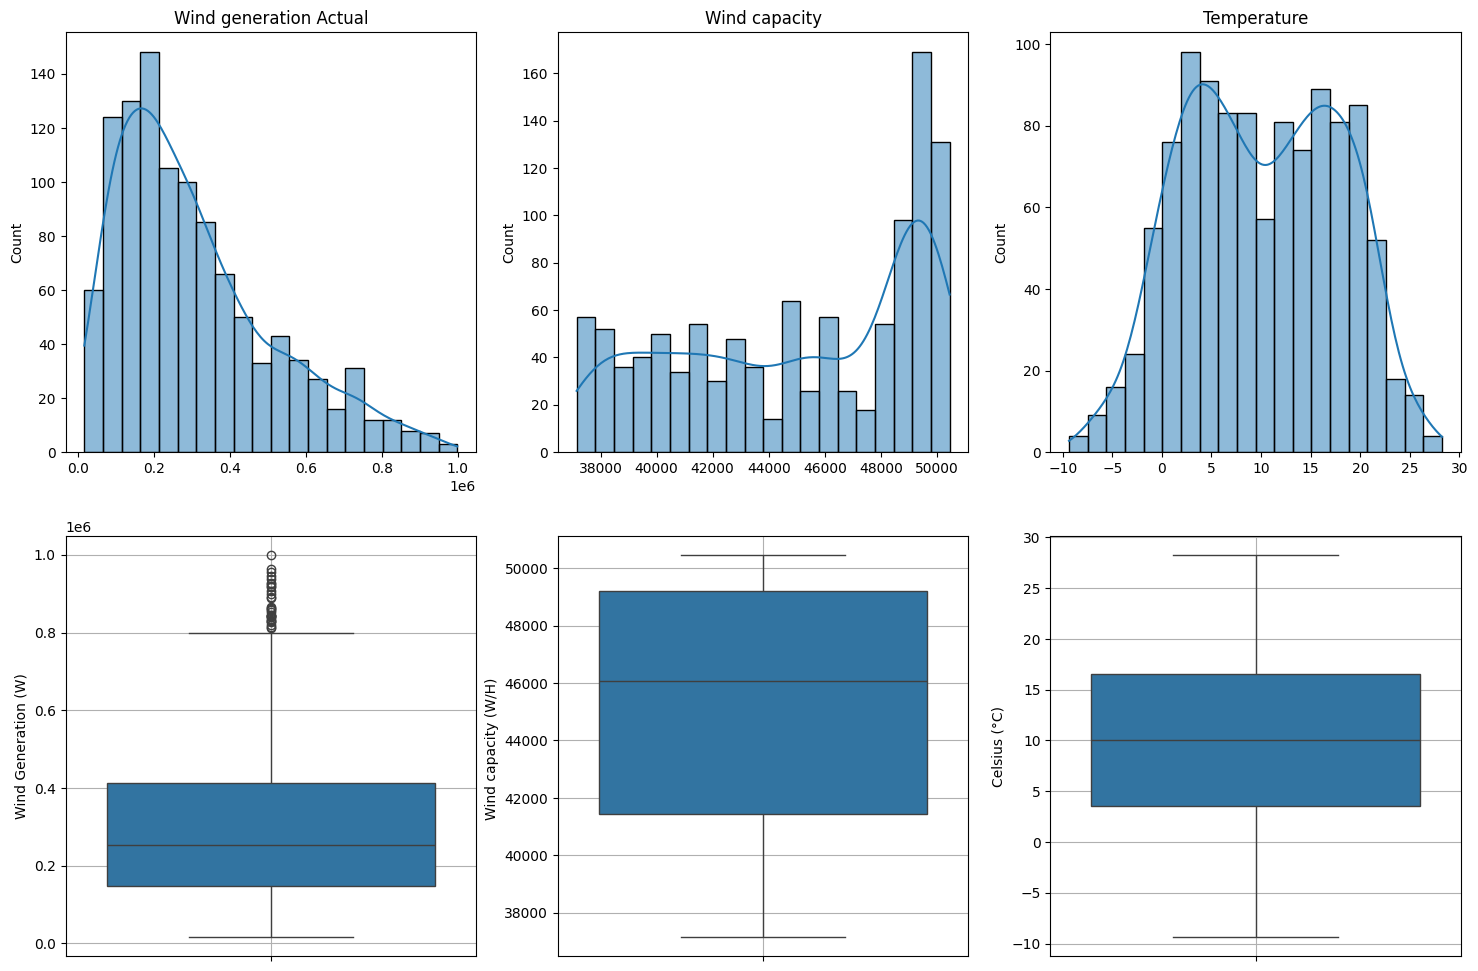

In [9]:
fig,ax = plt.subplots(2,3,figsize=(18,12))
sns.histplot(df_completed.wind_generation_actual, bins=20, kde=True,ax = ax[0,0])
ax[0,0].set_title('Wind generation Actual')
ax[0,0].set_xlabel('')
ax[1,0].set_ylabel('Wind Generation (W)')
sns.boxplot(df_completed.wind_generation_actual, ax=ax[1,0])
sns.histplot(df_completed.wind_capacity,bins=20,kde=True, ax=ax[0,1])
ax[0,1].set_title('Wind capacity')
ax[0,1].set_xlabel('')
ax[1,1].set_ylabel('Wind capacity (W/H) ')
sns.boxplot(df_completed.wind_capacity, ax=ax[1,1])
sns.histplot(df_completed.temperature,bins=20,kde=True, ax=ax[0,2])
ax[0,2].set_title('Temperature')
ax[0,2].set_xlabel('')
ax[1,2].set_ylabel('Celsius (°C)')
sns.boxplot(df_completed.temperature, ax=ax[1,2])
ax[1,0].grid()
ax[1,1].grid()
ax[1,2].grid()

We see that there are some outliers in the wind generation. Let's investigate more by calculating the IQR and then determine the total numbers of outliers.

In [10]:
# Note: IQR for defining an outlier

Q1_py = np.quantile(df_completed.wind_generation_actual,0.25)
Q3_py = np.quantile(df_completed.wind_generation_actual,0.75)
IQR = Q3_py-Q1_py
Lower_Fence = Q1_py - 1.5*IQR
Upper_Fence = Q3_py + 1.5*IQR

T = []
for i in df_completed.wind_generation_actual:
    exp1 = i < Lower_Fence
    exp2 = i > Upper_Fence
    if exp1 or exp2:
       temp = i
       T.append(temp)
print('The total number of outliers is ', len(T), 'which is rougly', round(len(T)/len(df_completed)*100,2), '% of the dataset')

The total number of outliers is  30 which is rougly 2.74 % of the dataset


## Correlation between the features

Another interesting thing to see is if there is correlations between the features. This will be useful in determining the type of model we are going to use to forecast data.

<Axes: >

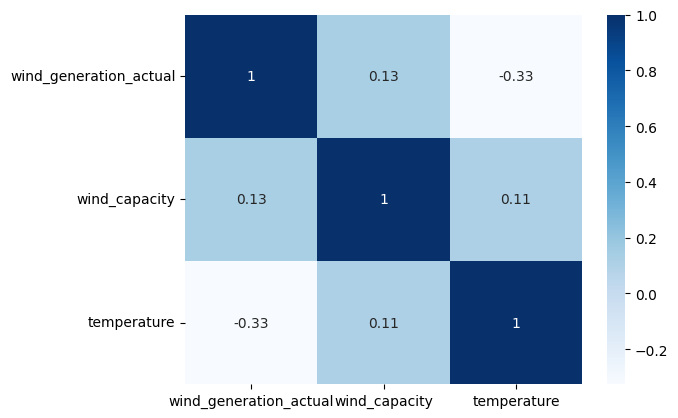

In [11]:
corr = df_completed.corr()
sns.heatmap(corr,annot=True,cmap='Blues')

It's possible to see that the data does not present strong correlation between the features. There is a slighly negative correlation between the wind_generation and the temperature. The reason why is the following: "Higher temperature air with identical composition to other lower temperature air will contain less energy are require a greater volume of mass (higher wind speed) to produce the same amount of power from a wind turbine" taken from https://www.quora.com/How-does-temperature-affect-wind-turbines#:~:text=If%20the%20temperature%20is%20too,wind%20turbine%20will%20stop%20working.

## Yearly information

I want to gather more information about the distribution yearly and moreover on the descriptive statistics of the data with the min, mean and max of each feature

Text(0.5, 1.0, 'Wind power Generation')

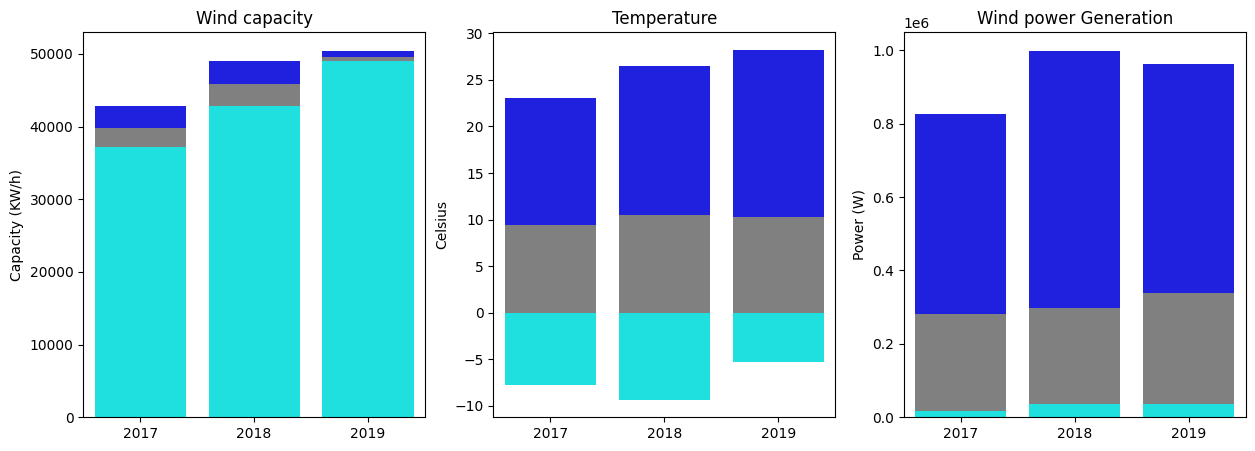

In [12]:
year_df_avg = df_completed.resample('1Y',).mean().add_suffix('_avg')
year_df_min = df_completed.resample('1Y',).min().add_suffix('_min')
year_df_max = df_completed.resample('1Y',).max().add_suffix('_max')
sns.color_palette("pastel")
year_df = pd.concat([year_df_avg, year_df_min, year_df_max], axis=1)
fig, ax = plt.subplots(1,3,figsize=(15,5))
sns.barplot(year_df['wind_capacity_max'], color='blue', ax=ax[0])
sns.barplot(year_df['wind_capacity_avg'], color='grey',ax=ax[0])
sns.barplot(year_df['wind_capacity_min'], color='cyan',ax=ax[0])
ax[0].set_ylabel('Capacity (KW/h)')
ax[0].set_xticks([0,1,2],['2017','2018','2019'])
ax[0].set_xlabel('')
ax[0].set_title('Wind capacity')
sns.barplot(year_df['temperature_max'], color='blue',ax=ax[1])
sns.barplot(year_df['temperature_avg'], color='grey',ax=ax[1])
sns.barplot(year_df['temperature_min'], color='cyan',ax=ax[1])
ax[1].set_ylabel('Celsius')
ax[1].set_xticks([0,1,2],['2017','2018','2019'])
ax[1].set_xlabel('')
ax[1].set_title('Temperature')
sns.barplot(year_df['wind_generation_actual_max'], color='blue',ax=ax[2])
sns.barplot(year_df['wind_generation_actual_avg'], color='gray',ax=ax[2])
sns.barplot(year_df['wind_generation_actual_min'], color='cyan',ax=ax[2])
ax[2].set_ylabel('Power (W)')
ax[2].set_xticks([0,1,2],['2017','2018','2019'])
ax[2].set_xlabel('')
ax[2].set_title('Wind power Generation')

It's possible to see that there is an increasing trend for the wind capacity for the reasons cited above. The temperature has an increasing too for the maximum temperatures reached, but if we look for the minimum ones (the cyan) then there is not an increasing trend and it's stabilized around 0. The wind power generation has an increasing minum from 2017 to 2018, but it stayed more or less the same for the year 2019.

We can try to see which is the month with the highest wind power generation and the one with the minimum power generation.

In [13]:
monthly_df = df_completed.resample('1M').max()
max_mask = monthly_df.wind_generation_actual ==  monthly_df.wind_generation_actual.max()
max_month = monthly_df[max_mask]
print("Month with maximum generation ",max_month.index[0].strftime('%m/%y'))

monthly_df = df_completed.resample('1M').min()
min_mask = monthly_df.wind_generation_actual ==  monthly_df.wind_generation_actual.min()
min_month = monthly_df[min_mask]
print("Month with minimum power generation:", min_month.index[0].strftime('%m/%y'))

monthly_df = df_completed.resample('1M').mean()
avg_month = monthly_df[monthly_df.wind_generation_actual == monthly_df.wind_generation_actual.max()]
print("Month with biggest avergae power generation:", avg_month.index[0].strftime('%m/%y'))

Month with maximum generation  12/18
Month with minimum power generation: 09/17
Month with biggest avergae power generation: 03/19


Text(0.5, 1.0, 'Wind generation of March 2019')

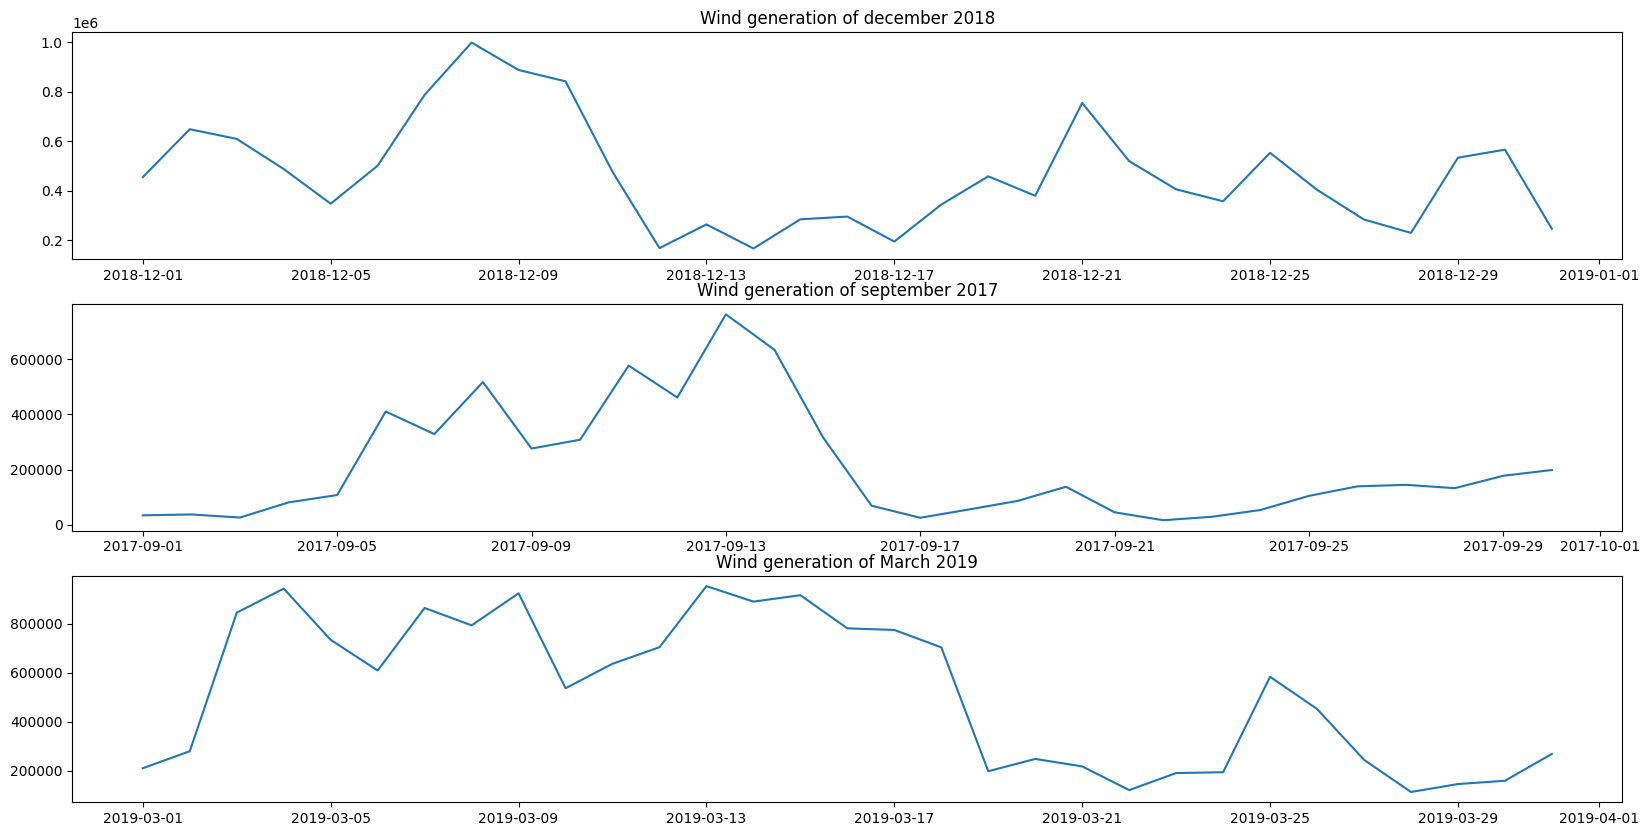

In [14]:
fig, ax = plt.subplots(3,1, figsize=(20,10))
max_df = df_completed['2018-12-1':'2018-12-31']['wind_generation_actual']
ax[0].plot(max_df)
ax[0].set_title(f'Wind generation of december 2018')
ticks = df_completed['2017-09-1':'2017-09-30'].index.strftime('%d/%m/%y')
ax[1].plot(df_completed['2017-09-1':'2017-09-30']['wind_generation_actual'])
ax[1].set_title(f'Wind generation of september 2017')
ticks = df_completed['2019-03-01':'2019-03-31'].index.strftime('%d/%m/%y')
ax[2].plot(df_completed['2019-03-1':'2019-03-31']['wind_generation_actual'])
ax[2].set_title(f'Wind generation of March 2019')

From these plots it's possible to see in a bigger picture how the wind generation changed on the months with highest wind generation, minimum or with the highest average. It's clearly visible from the second plot that the lowest has been reached probabl

# Split of the data
From the document 'The main aim of this project is to forecast the wind power generation for the last month of 2019 (December)'. So the test set is going to be only the month of december 2019 and the train set will be the other part.

In [15]:
#Splitting the data in the train and test set. As mentioned in the project document, the month of december is going to be our test set
train_data = df_completed[:'2019-12-01']
test_data = df_completed['2019-12-01':]
wind_generation_daily_train = df_completed['wind_generation_actual'][:'2019-12-01']
wind_generation_daily_test = df_completed['wind_generation_actual']['2019-12-01':]

#Printing the dimensions of the two dataframes
print('Shape of the splitted dataset: ','\nTrain: ',wind_generation_daily_train.shape,'\nTest: ', wind_generation_daily_test.shape)
print(wind_generation_daily_train.head())
print(wind_generation_daily_test.head())

Shape of the splitted dataset:  
Train:  (1065,) 
Test:  (30,)
utc_timestamp
2017-01-01 00:00:00+00:00    291760.0
2017-01-02 00:00:00+00:00    295097.0
2017-01-03 00:00:00+00:00    666170.0
2017-01-04 00:00:00+00:00    686581.0
2017-01-05 00:00:00+00:00    261759.0
Freq: D, Name: wind_generation_actual, dtype: float64
utc_timestamp
2019-12-01 00:00:00+00:00    134296.0
2019-12-02 00:00:00+00:00    344119.0
2019-12-03 00:00:00+00:00    275830.0
2019-12-04 00:00:00+00:00    278977.0
2019-12-05 00:00:00+00:00    436209.0
Freq: D, Name: wind_generation_actual, dtype: float64


In [ ]:
#Replot of the data we are intersted in forecasting.
plt.figure(figsize=(20,6))
sns.lineplot(data=df_completed, x="utc_timestamp",y="wind_generation_actual")
plt.ylabel("Wind generation (W)")
plt.xlabel('Time')
plt.title("Wind generation through the years")

## Approach method
* Check for stationarity of the data
* Determine the seasonality of the data
* Make the data stationary by applying differenciation
* Perform ACF and PACF analysis to gather the parameters for the model part
* Train the models and get the predictions
* Compare the models used by MAE and MSE  and AIC




To determine if our data is stationary or not we have to use the KPSS and the ADFuller tests which have different hypothesis and can be done separated.

## Test Stationary

In [16]:
#Execute an AdFuller test on the data. If the p-value is less than <=0.05 the data is stationary, otherwise it is not.
def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')
#Execute a KPSS test on the data passed by the argument. If the p-value is less than 0.05 then null hypothesis cannot be rejected
# and that's means the data is not trend stationary, otherwise is trend stationary.
def kpss_test(data):
  kpss_out = kpss(data,regression='ct', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')

<i>Remember</i>
<hr/>
<u>Important Note</u>: These two tests are not interchangeble, considering their different assumptions/null hypotheses. It is always better to apply both of them, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

- **Case 1**: Both tests conclude that the series is not stationary - The series is not stationary.

- **Case 2**: Both tests conclude that the series is stationary - The series is stationary.

- **Case 3**: KPSS indicates stationarity and ADF indicates non-stationarity -> The series is trend stationary: it requires operations to remove the trend. The resulting detrended series is checked for stationarity.

- **Case 4:** KPSS indicates non-stationarity and ADF indicates stationarity ->  The series is difference stationary: it requires differencing. The differenced series is checked for stationarity.

In [17]:
adfuller_test(wind_generation_daily_train)
kpss_test(wind_generation_daily_train)

ADF Statistic: -10.770881147570158
p-value:  2.3860555693459234e-19
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
We can reject the null hypothesis (H0) --> data is stationary
KPSS Statistic: 0.16055636659787048
p-value:  0.03786969450177459
We can reject the null hypothesis (H0) --> data is not trend stationary


The AdFuller tests is less than the p-value of 0.05 so we can reject the null hypothesis, meaning that it stationary.
The KPSS test says that our data is not trend stationary and so we have to do some differencing to get the stationary, it's usually adviced to remove first the seasonality part and then do the differencing.

## Frequency analysis
To determine the seasonality a good way is to use the frequency analyisis which calculates the most frequency densities and by sorting the highest ones we can determine the seasonality (period) of the data by just doing 1/freq.

   Frequency       Density      Period
0   0.002817  6.622174e+12  355.000000
1   0.006573  1.146676e+11  152.142857
2   0.011268  3.955245e+11   88.750000
3   0.014085  1.126715e+11   71.000000
4   0.015962  1.434301e+11   62.647059


Text(0, 0.5, 'Power')

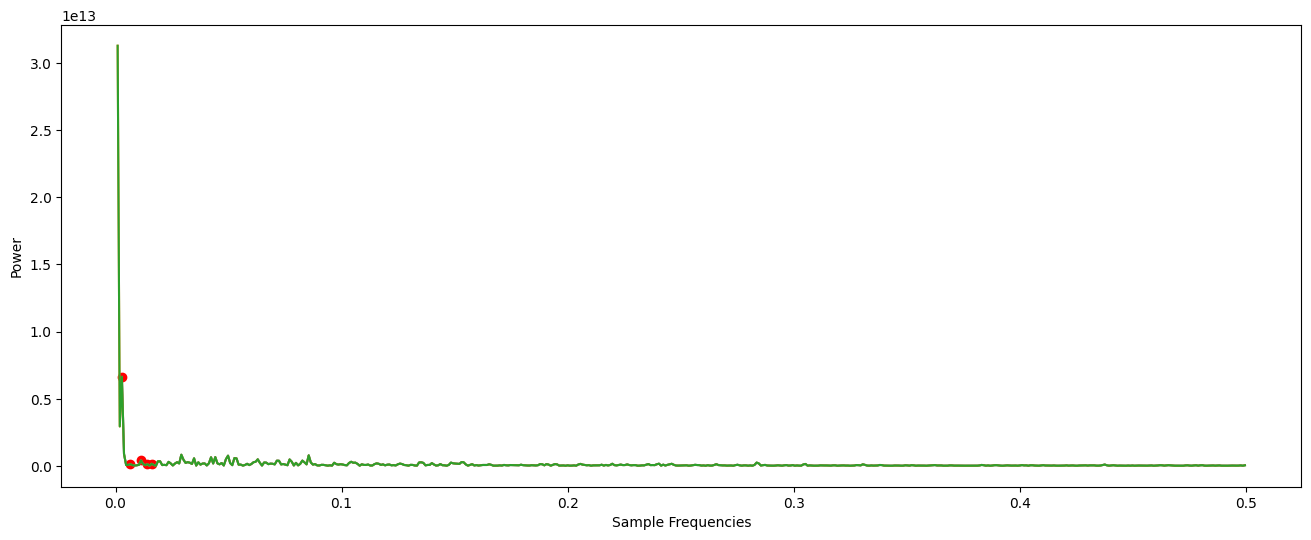

In [18]:
###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.
f_per, Pxx_per = signal.periodogram(wind_generation_daily_train,1,detrend=None,window='hann',return_onesided=True,scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

#Find the peaks of the periodogram.
peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=100000)[0]
peak_freq = f_per[peaks]
peak_dens = Pxx_per[peaks]

#Plot of the analysis transformation and of its peaks. Only the first five are interestings
fig = plt.figure(figsize=(16,6))

plt.plot(peak_freq[:5], peak_dens[:5], 'ro');
plt.plot(f_per[2:],Pxx_per[2:])

#Retrieving of the values
data = {'Frequency': peak_freq, 'Density': peak_dens, 'Period': 1/peak_freq}
df = pd.DataFrame(data)

print(df.head())
sns.lineplot(x=f_per,y=Pxx_per)
plt.plot(f_per, Pxx_per)
plt.xlabel('Sample Frequencies')
plt.ylabel('Power')


We see that the most highest frquencies represents the periods 355, 152, 88, 71 and 62 days. So we have five guesses for the seasonalities, it's common that a time series has more than one seasonality. For mine purpose i'll use the seasonality of 355 approximated to 365 (yearly seasonality) and then the 88 approximated do 90 (three month seasonality.)

### Apply seasonal difference to our data

Since the data is not stationary we have to do a difference on the starting dataset. From the spectral analysis we have that the most recurrent period is 355 which can be seen as an yearly seasonality. In the next section we are going to do a difference of 365 to the data and then test the stationary.


Text(0.5, 1.0, 'Wind Energy production diffed 365.')

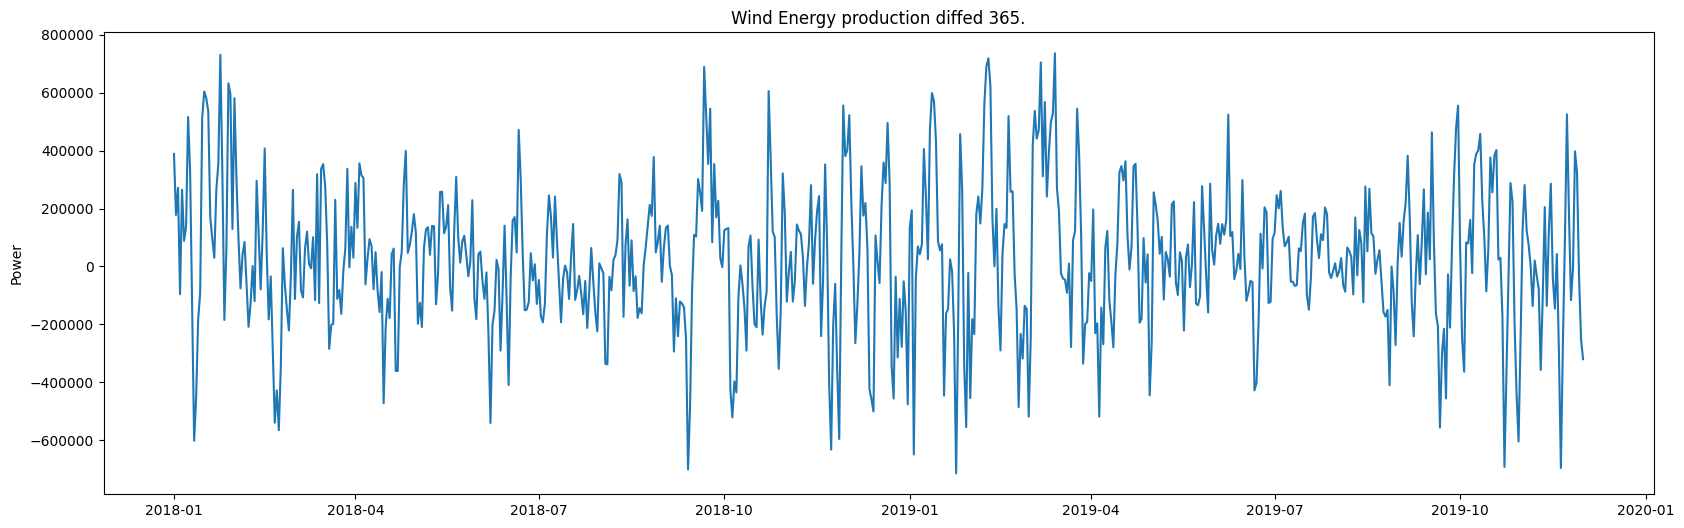

In [19]:
wind_generation_daily_diff_train = wind_generation_daily_train.diff(365).dropna()
train_data_diff = train_data.diff(365).dropna()
fig = plt.figure(figsize=(20,6))
plt.plot(wind_generation_daily_diff_train)
plt.ylabel('Power')
plt.title('Wind Energy production diffed 365.')

We now apply the stationary test to see if this is enough to make our data stationary.

In [20]:
adfuller_test(wind_generation_daily_diff_train)
kpss_test(wind_generation_daily_diff_train)

ADF Statistic: -13.767585382019107
p-value:  9.818651975747313e-26
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
We can reject the null hypothesis (H0) --> data is stationary
KPSS Statistic: 0.06629966536457006
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


## ACF and PACF

The ACF and PACF are useful tools which can be largely used to detect properties of the time series, respectively they are the autocorelation function and the partial autocorrelation function, the term auto refers to the fact that the correlation is on the same data and not on different sets. If we see lot of lags with values which are outside the blue surface then it means that at this specific lag there is some correlation of the data and it is not a good sign for us. In the first case we'll see how the ACF and PACF are before applying the seasonal difference and then for the second plots I'll use the diffed data.

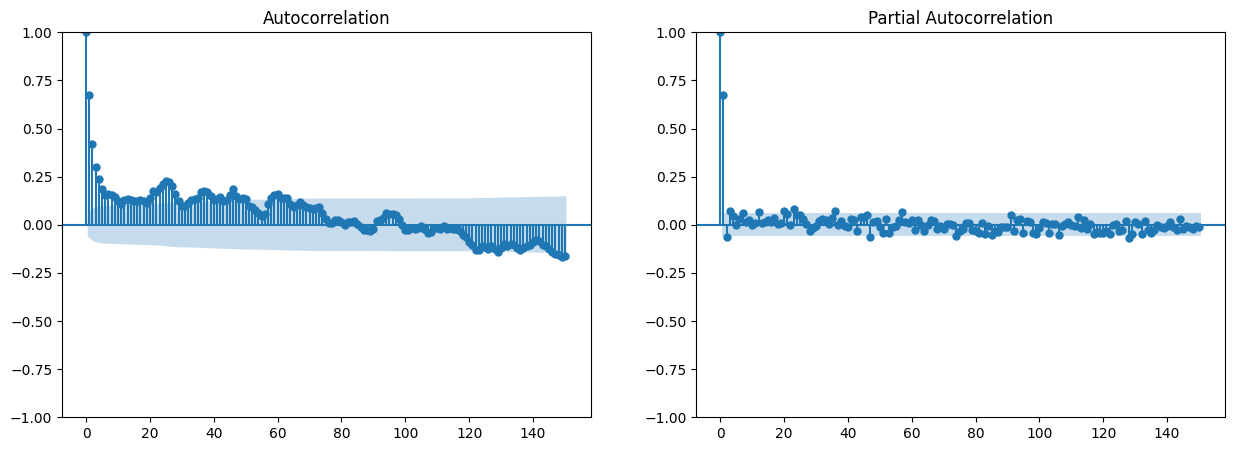

In [21]:
utils.plot_autocorr(wind_generation_daily_train, lags=150)

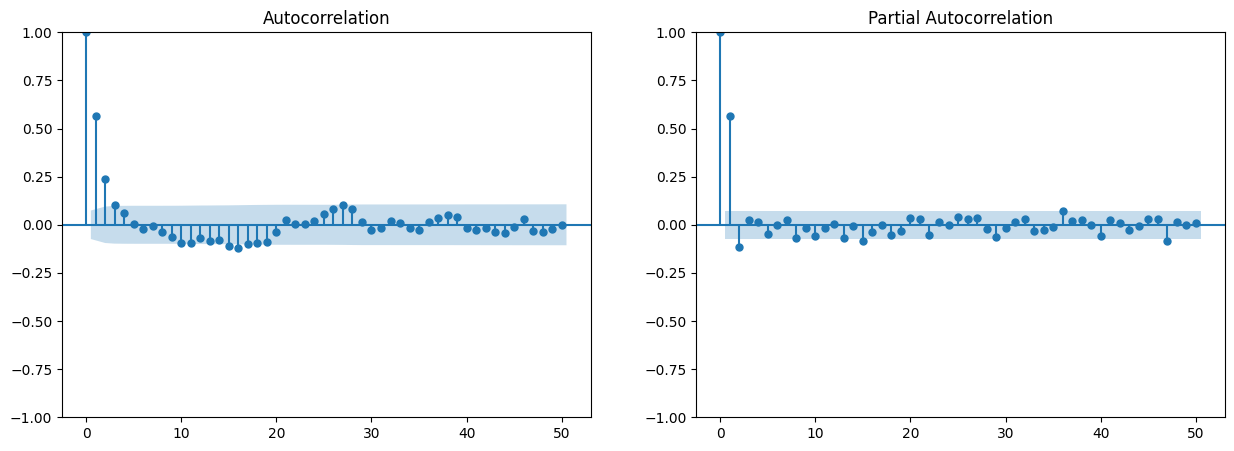

In [22]:
utils.plot_autocorr(wind_generation_daily_diff_train, lags=50)

It's clearly visible the effect of the difference on the data. On the first case there are a lot of outlier who are outside the "confidence-interval" and that means a lot of the data at different lags is correlated to each other.

## Cointegration:
The Null hypothesis is that there is no cointegration, the alternative hypothesis is that there is cointegrating relationship. If the pvalue is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship.



In [23]:
score, pvalue, crit_val = st.coint(df_completed['wind_generation_actual'], df_completed['temperature'], maxlag=20)
print('pval for cointegration test is:', pvalue)
#We can reject the null hypothesis. There is cointegrating relationship.

pval for cointegration test is: 1.0248699690744003e-27


The p-value is strictly lower than the critical value and so there we can clearly reject the null hypothesis

# Problem
Having a seasonality that's so big is a huge problem for the Sarima Model. As said here by one of the author of the book 'Forecasting Principles and Practice' https://robjhyndman.com/hyndsight/longseasonality/ having a seasonality that's in the order of hundreds is too big for the model to handle.
There are few solutions to this:
<ol>
    <li>Fourier transformation of the data trying to handle the seasonality.</li>
    <li>Processing the data => transforming daily data into weekly or monthly by an aggregation function.</li>
    <li>Use models that can handle big seasonalities.</li>
</ol> 
I've decided to choose the second option.

# Metrics table

To save all the values and properties of each model, i've decided to use a dataframe in which I insert those values inside

In [24]:
df_metrics = pd.DataFrame(columns=['Model_name','AIC','MAE','RMSE','MAPE'])
display(df_metrics)

Empty DataFrame
Columns: [Model_name, AIC, MAE, RMSE, MAPE]
Index: []

# SARIMA

## Sampling of the data

All the data is grouped into weekly basis with respect to the average of all seven days in a week.

In [25]:
df_weekly = df_completed.resample('1W').mean()

In [26]:
print("New Dataset shape: ",df_weekly.shape)

New Dataset shape:  (158, 3)


Having grouped the data into weekly values, the test set results in only 4 values versus the 30 in the daily case. 
So for mine purpose i'll use the last three months for the test sets.

In [28]:
data_train = df_weekly['wind_generation_actual'][:-13]
data_test = df_weekly['wind_generation_actual'][-13:]
display(data_train.head())
display(data_train.shape)
display(data_test.head())
display(data_test.shape)


utc_timestamp
2017-01-01 00:00:00+00:00    291760.000000
2017-01-08 00:00:00+00:00    331270.714286
2017-01-15 00:00:00+00:00    418425.000000
2017-01-22 00:00:00+00:00     94920.000000
2017-01-29 00:00:00+00:00    163572.571429
Freq: W-SUN, Name: wind_generation_actual, dtype: float64

(145,)

utc_timestamp
2019-10-13 00:00:00+00:00    546193.428571
2019-10-20 00:00:00+00:00    342129.714286
2019-10-27 00:00:00+00:00    376999.142857
2019-11-03 00:00:00+00:00    291519.285714
2019-11-10 00:00:00+00:00    188044.142857
Freq: W-SUN, Name: wind_generation_actual, dtype: float64

(13,)

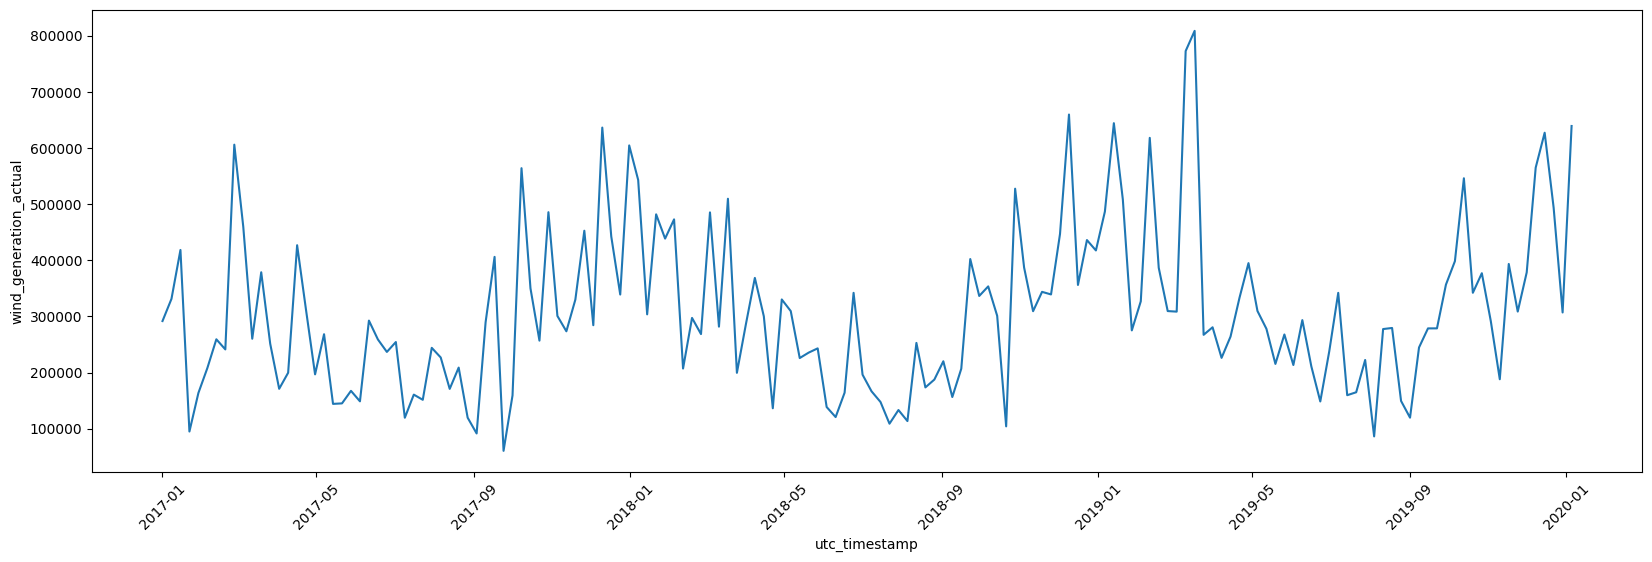

In [29]:
fig = plt.figure(figsize=(20,6))
sns.lineplot(df_weekly,x='utc_timestamp', y='wind_generation_actual')
v = plt.xticks(rotation=45)

## Stationary test on Weekly Data

In [30]:
#Doing the test for stationarity we see that the data is not stationary.
adfuller_test(data_train)
kpss_test(data_train)
#The ADFuller test can't reject the null hypothesis, this means that the data is non-stationary.
#Following the indications above, we see that if the ADF explicitly tell us that the time series is not statoinary, and the KPSS says that the Time series
#is trend stationary, then the series is difference stationary and requires differencing.

ADF Statistic: -2.2550841820415526
p-value:  0.18686345881574057
Critical Values:
	1%: -3.478
	5%: -2.883
	10%: -2.578
We cannot reject the null hypothesis (H0) --> data is non-stationary
KPSS Statistic: 0.08445163186979426
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


Having grouped daily the data we do not know if the seasonality calculated before is the same as the one right now. So let's redo the periodogram to determine the most frequent periods and hope that those do not change.

## Frequency Analysis

   Frequency       Density     Period
0   0.020690  8.157474e+11  48.333333
1   0.048276  1.256319e+10  20.714286
2   0.062069  2.829531e+09  16.111111
3   0.082759  3.568376e+10  12.083333
4   0.096552  1.521905e+10  10.357143


Text(0, 0.5, 'Power')

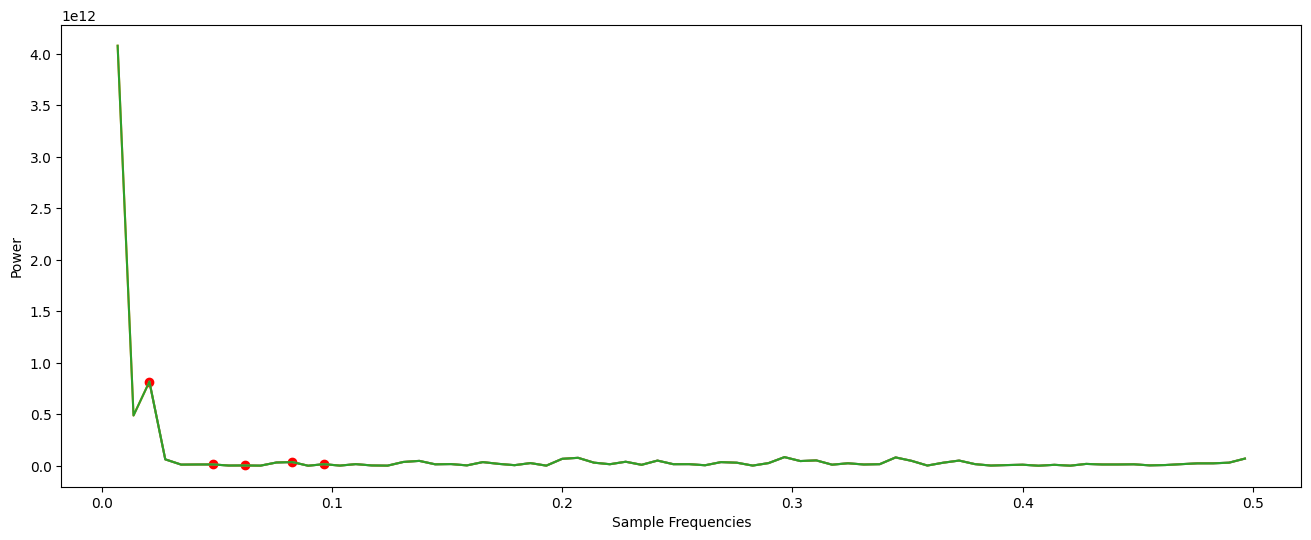

In [31]:
###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.
f_per, Pxx_per = signal.periodogram(data_train,1,detrend=None,window='hann',return_onesided=True,scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

#Find the peaks of the periodogram.
peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=100000)[0]
peak_freq = f_per[peaks]
peak_dens = Pxx_per[peaks]

#Plot of the analysis transformation and of its peaks. Only the first five are interestings
fig = plt.figure(figsize=(16,6))

plt.plot(peak_freq[:5], peak_dens[:5], 'ro');
plt.plot(f_per[2:],Pxx_per[2:])

#Retrieving of the values
data = {'Frequency': peak_freq, 'Density': peak_dens, 'Period': 1/peak_freq}
df = pd.DataFrame(data)
print(df.head())
sns.lineplot(x=f_per,y=Pxx_per)
plt.plot(f_per, Pxx_per)
plt.xlabel('Sample Frequencies')
plt.ylabel('Power')


The values stayed consistently as in the case of the daily data. So I'm going to use seasonality of 90 days for computations problems and so by weeks it's 

In [32]:
#So we proceed to remove the seasonality that we've calculated before.
data_train_diff = data_train.diff(52).dropna()
adfuller_test(data_train_diff)
kpss_test(data_train_diff)

ADF Statistic: -8.749158045314738
p-value:  2.8678153797583165e-14
Critical Values:
	1%: -3.504
	5%: -2.894
	10%: -2.584
We can reject the null hypothesis (H0) --> data is stationary
KPSS Statistic: 0.127799946431593
p-value:  0.08370380290445738
We cannot reject the null hypothesis (H0) --> data is trend stationary


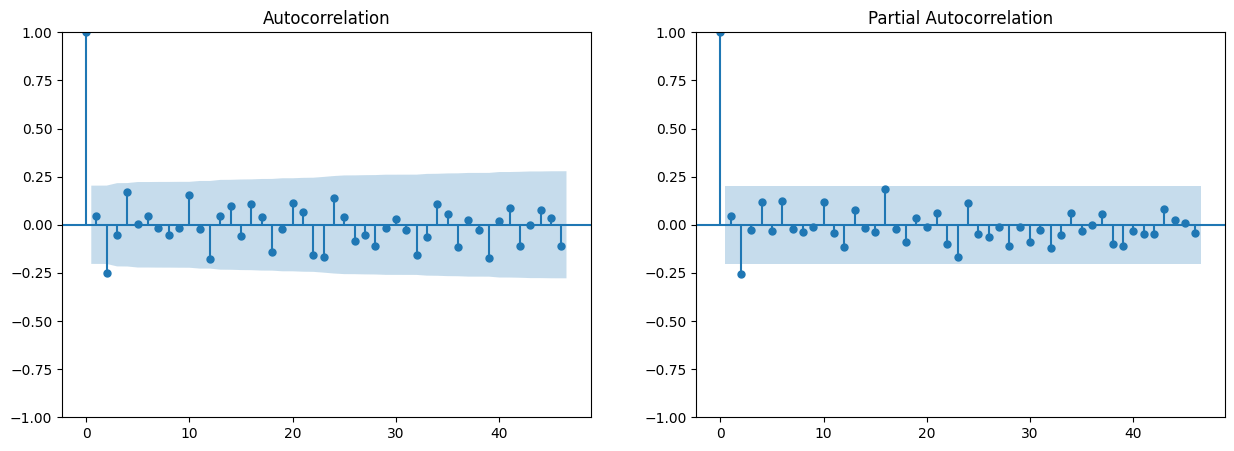

In [33]:
#So by dropping the seasonality we've seen that the data is now stationary. Proceeding to plot the ACF and PACF
utils.plot_autocorr(data_train_diff, 46)
#There is not a lot of autocorrelaiton of the data, we can see two little spikes at lags 2 in the ACF and PACF, but other than that we can't 
#deduce better results.

This is the max of what we get from the ACF and PACF, honestly we could go a little bit more on the ACF one but the PACF requires more data samples which we can't get.

## Manual SARIMA

In [34]:
import math

In [35]:
(p, d, q) = (1,0,1)
S = 52
D = 1

### Grid Search: Estimate the best Parameters

In [ ]:
#DO NOT RUN, IT'S COMPUTATIONAL HEAVY!!! 
best_aic = math.inf
best_Q = 0
best_P = 0
for P in range(0, 5):
    for Q in range(0, 5):
        model = SARIMAX(data_train, 
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,S), 
                       enforce_stationarity=False,
                       enforce_invertibility=False) 
        result = model.fit(disp=False)
        if result.aic < best_aic and (not np.isnan(result.bic) or not np.isnan(result.hqic)):
            best_aic = result.aic
            best_Q = Q
            best_P = P

After running the Grid Search above, the best P and Q are respectively 0 and 2.

In [36]:
best_P = 0
best_Q = 2

After calculating all the parameters, it's possible to create the model and then fit it with the train data.

In [42]:
best_manual_Sarima_model = SARIMAX(data_train, 
                       order=(p,d,q), 
                       seasonal_order=(best_P,D,best_Q,S), 
                       enforce_stationarity=True,
                       enforce_invertibility=False) 

In [43]:
result_best_manual_SARIMA = best_manual_Sarima_model.fit(disp=False)

                                        SARIMAX Results                                        
Dep. Variable:                  wind_generation_actual   No. Observations:                  145
Model:             SARIMAX(1, 0, 1)x(0, 1, [1, 2], 52)   Log Likelihood               -1237.130
Date:                                 Thu, 01 Feb 2024   AIC                           2484.261
Time:                                         18:54:02   BIC                           2496.924
Sample:                                     01-01-2017   HQIC                          2489.374
                                          - 10-06-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1692      0.437     -0.387      0.698      -1.025       0

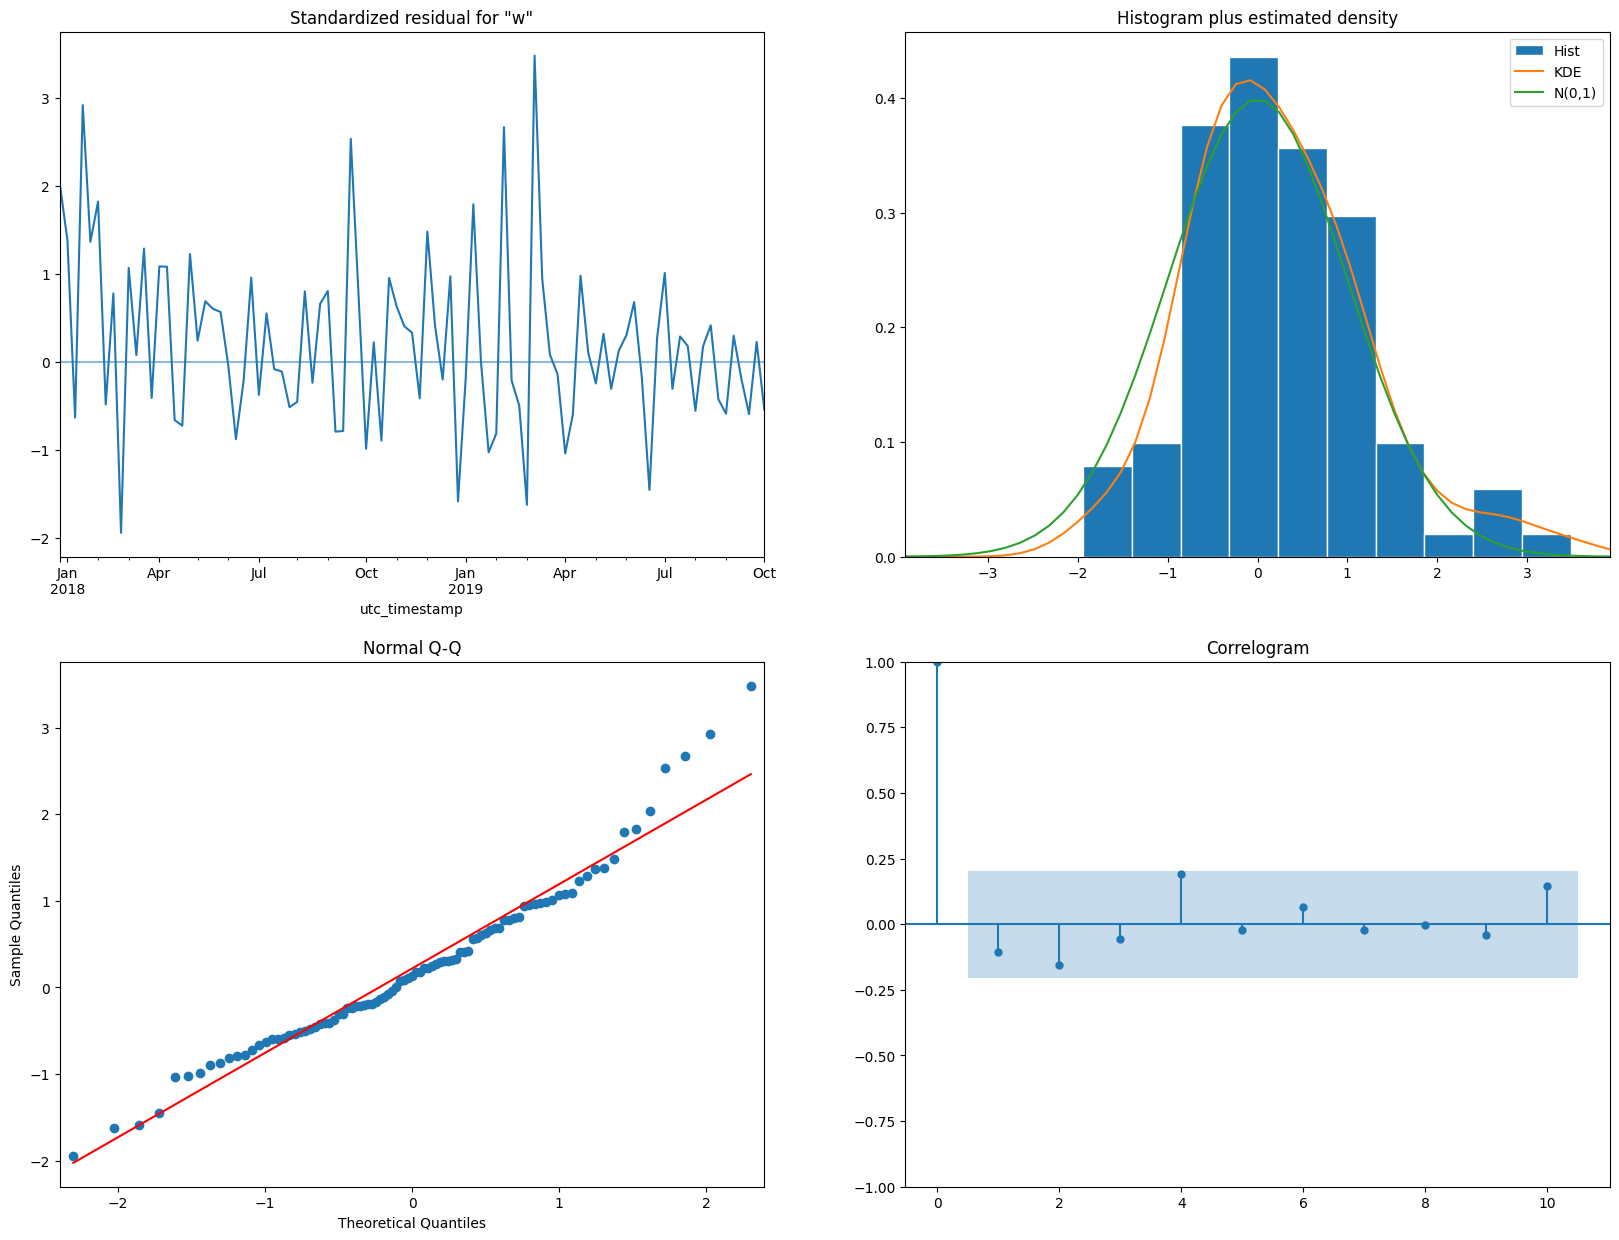

In [44]:
print(result_best_manual_SARIMA.summary())
result_best_manual_SARIMA.plot_diagnostics(figsize=(20, 15));

### Residual Tests

In [45]:
print('Durbin watson: ',durbin_watson(result_best_manual_SARIMA.resid))

Durbin watson:  0.9749393780486248


A result which is lower than 2 means that the residuals are positively correlated and this means that our model is not using all the available information from the data. It's possible to compute the Ljung-box test to see if it says different things.

In [47]:
# H0: The residuals are independently distributed.
# H1: The residuals are not independently distributed; they exhibit serial correlation
ljung_test = acorr_ljungbox(result_best_manual_SARIMA.resid, period=52)
ljung_test.head()

lb_stat     lb_pvalue
1  14.564095  1.354714e-04
2  25.803607  2.493550e-06
3  43.201705  2.229895e-09
4  71.637317  1.023817e-14
5  82.223912  2.873211e-16

### Predictions

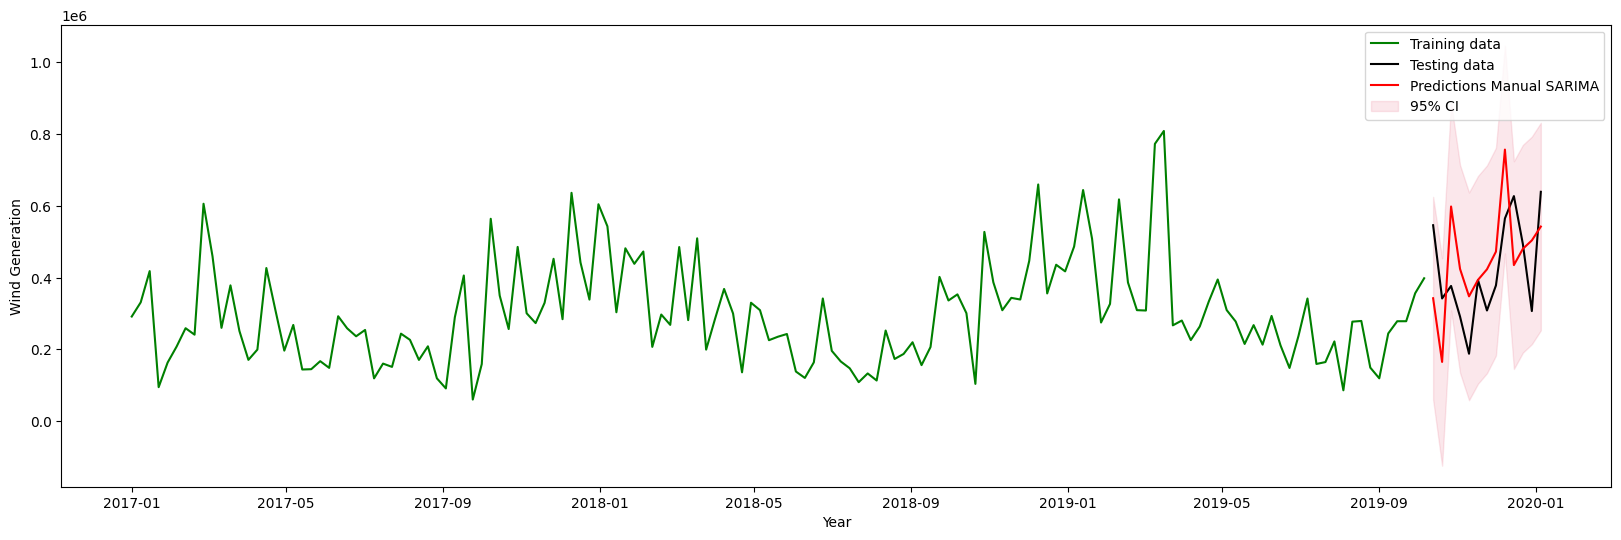

In [48]:
model_SARIMA = result_best_manual_SARIMA.get_prediction(start=data_test.index[0], end=data_test.index[-1])
df_sarima = model_SARIMA.summary_frame()
plt.figure(figsize=(20, 6)) 
plt.plot(data_train, color='green',label='Training data')
plt.plot(data_test, color='black', label='Testing data')
plt.plot(df_sarima['mean'], color='red', label='Predictions Manual SARIMA')
plt.fill_between(df_sarima.index, df_sarima['mean_ci_lower'], df_sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Wind Generation')

plt.legend();

Overall the result is not so bad, but it's possible to increase the performance of our model using the auto-sarima function from pmdarima.

In [49]:
manual_sarima = pd.Series({'Model_name':'Sarima Manual', 'AIC':result_best_manual_SARIMA.aic, 'RMSE': mean_squared_error(data_test, df_sarima['mean'], squared=False),
                 'MAE': mean_absolute_error(data_test, df_sarima['mean']), 'MAPE':mean_absolute_percentage_error(data_test, df_sarima['mean'])})
df_metrics = pd.concat([df_metrics, manual_sarima.to_frame().T])

## Auto Sarima

We can clearly see that the paramaters are not the best ones and it can be seen in QQ plot. So there are two ways to determine the best paramters for the model: 
* grid search: trying all possible permutations of the paramters to get the best model
* auto arima: method which search for the best parameters.
We saw the grid search in the case of the arima in which the parameter (p, q) are estimated by hand, so let's use the auto arima to find the best parameters.

In [ ]:
#Auto arima
from pmdarima import auto_arima
arima_model = auto_arima(data_train, start_p=0, start_q=0, d=0,
                           max_p=3, max_q=3, m=52,
                           start_P=0, start_Q=0, max_P = 3, max_Q = 3, D = 1, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',  
                           suppress_warnings=True, 
                           n_jobs=4,
                           stepwise=True)
#ARIMA(1,0,1)(0,1,1)[52]

The best paramter gained from the auto arima are the following

In [52]:
(p, d, q) = (1,0,1)
(P, D, Q) = (0,1,1)
S = 52

In [53]:
#Create the model
model = SARIMAX(data_train, 
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,S), 
                       enforce_invertibility=False) 
#Fit
result_SARIMA_auto = model.fit(disp=False)

                                     SARIMAX Results                                      
Dep. Variable:             wind_generation_actual   No. Observations:                  145
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -1238.736
Date:                            Thu, 01 Feb 2024   AIC                           2485.473
Time:                                    18:56:14   BIC                           2495.603
Sample:                                01-01-2017   HQIC                          2489.563
                                     - 10-06-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0286      0.380     -0.075      0.940      -0.773       0.716
ma.L1          0.2974      0.354   

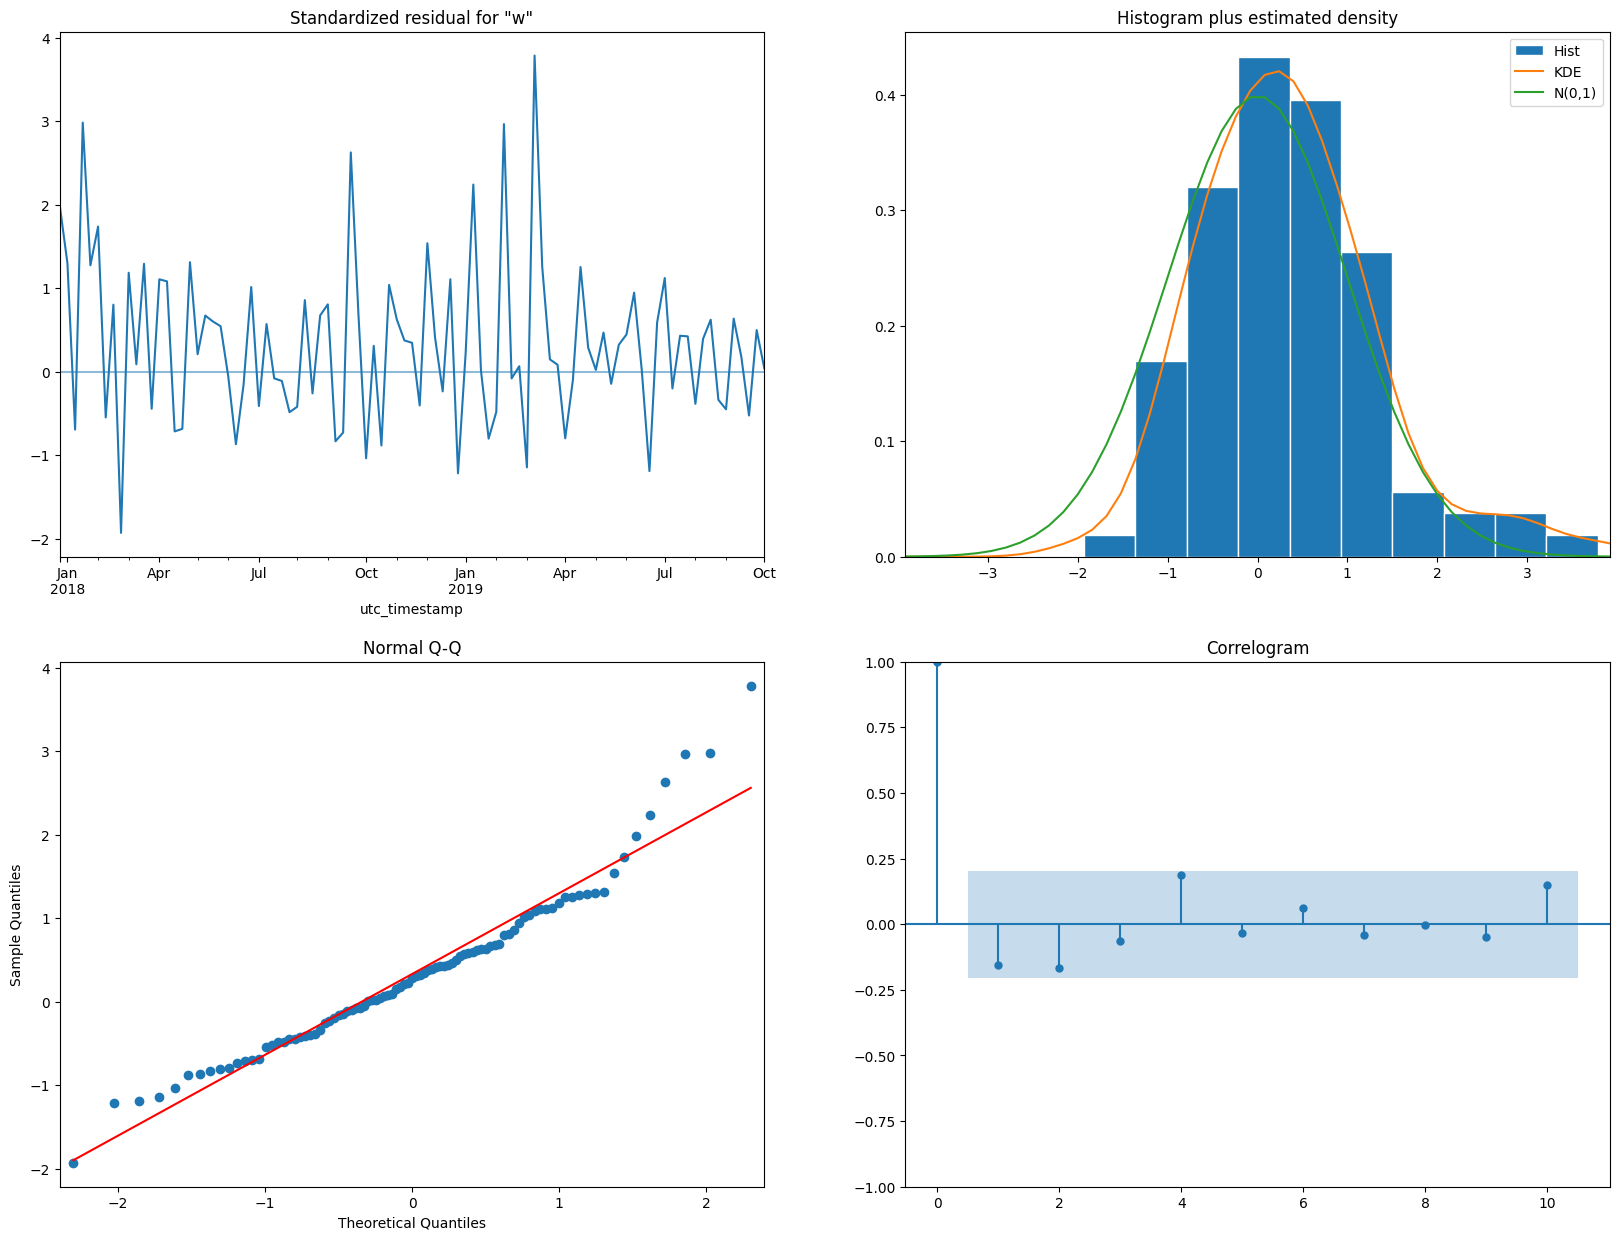

In [54]:
print(result_SARIMA_auto.summary())
result_SARIMA_auto.plot_diagnostics(figsize=(20, 15));

The residuals plot shows that there is a lot of flatuation between the residuals and the fitted values. So we expect that the forecasting is not going to produce a good forecast.

### Residuals Test

In [55]:
print('Durbin watson: ',durbin_watson(result_SARIMA_auto.resid))
#The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals.
#Thus, for r == 0, indicating no serial correlation, the test statistic equals 2. 
#This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. 
#The closer to 4, the more evidence for negative serial correlation.
#There is a positive correlation between the residuals. So this means that we did not use the most information

Durbin watson:  1.0509824137799189


In [56]:
ljung_test = acorr_ljungbox(result_SARIMA_auto.resid, period=52)
ljung_test.head()

lb_stat     lb_pvalue
1   6.842877  8.899541e-03
2  12.472265  1.957411e-03
3  24.385346  2.075480e-05
4  46.214912  2.221829e-09
5  51.519691  6.767919e-10

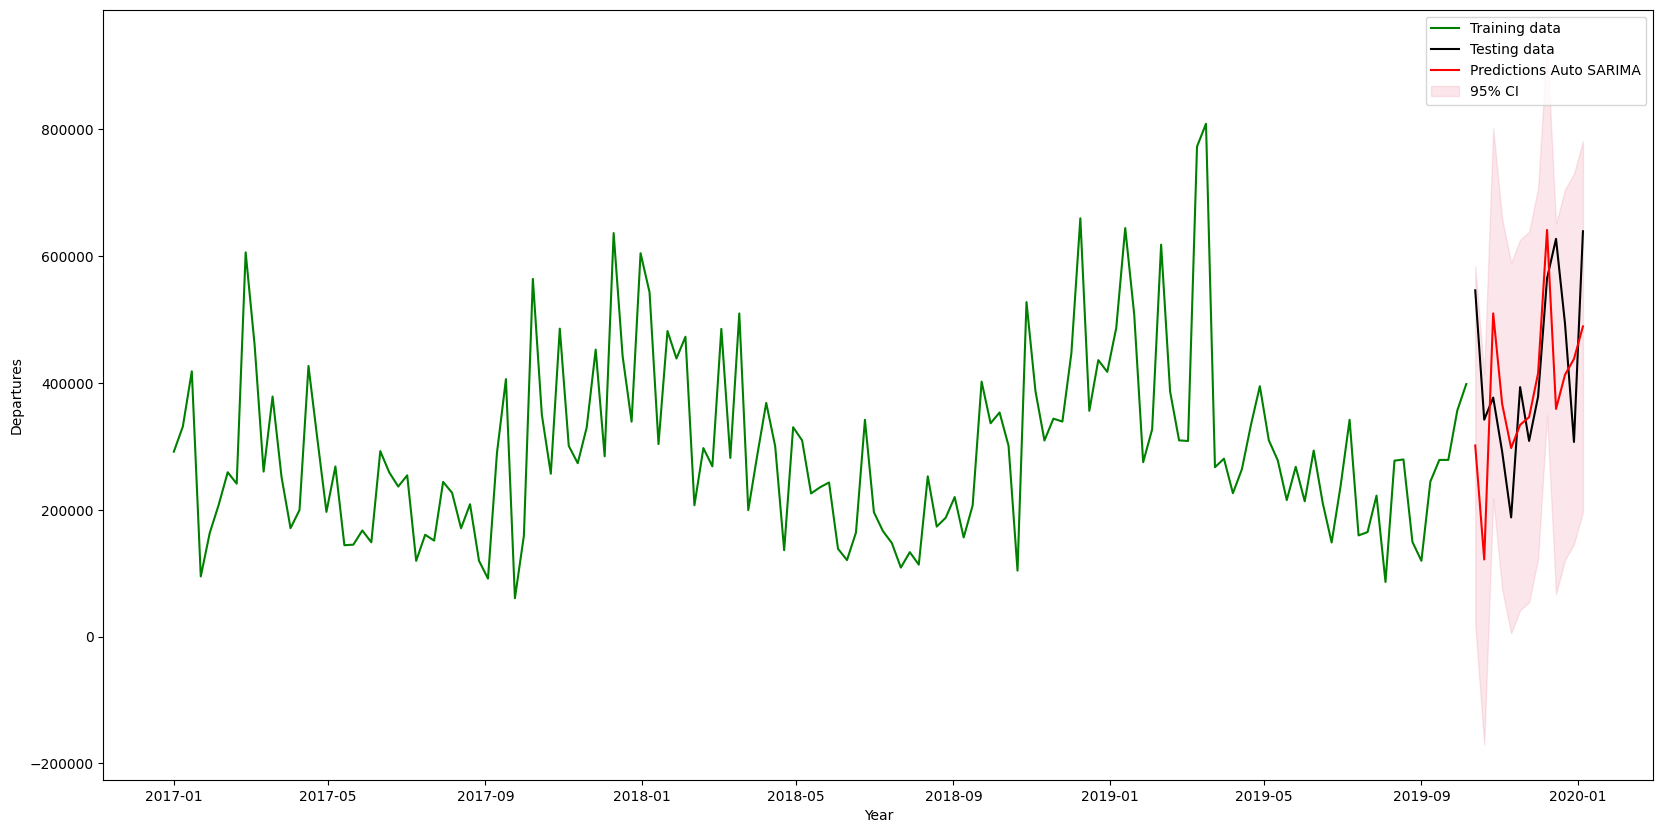

In [57]:
model_SARIMA = result_SARIMA_auto.get_prediction(start=data_test.index[0], end=data_test.index[-1])
df_auto_sarima = model_SARIMA.summary_frame()
plt.figure(figsize=(20, 10)) 
plt.plot(data_train, color='green',label='Training data')
plt.plot(data_test, color='black', label='Testing data')
plt.plot(df_auto_sarima['mean'], color='red', label='Predictions Auto SARIMA')
plt.fill_between(df_auto_sarima.index, df_auto_sarima['mean_ci_lower'], df_auto_sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Departures')

plt.legend();

In [58]:
auto_sarima = pd.Series({'Model_name':'Auto Sarima', 'AIC':result_SARIMA_auto.aic, 'RMSE': mean_squared_error(data_test, df_auto_sarima['mean'], squared=False),
                 'MAE': mean_absolute_error(data_test, df_auto_sarima['mean']), 'MAPE':mean_absolute_percentage_error(data_test, df_auto_sarima['mean'])})
df_metrics = pd.concat([df_metrics, auto_sarima.to_frame().T])

# SARIMAX

I've other two features in the dataset that we can exploit to get a better forecasting: temperature and wind_capacity.
Before I've calculated the correlation matrix of the data and noted that there was a negative correlation between the temperature and the wind_generation_actual. Let's see if using this feautres increases our model predictions.

## Prepare the data

In [59]:
#Calculate exogenous variables

###Wind Capacity###
wind_capacity_weekly = df_completed['wind_capacity']
wind_capacity_weekly = wind_capacity_weekly.resample("W").mean()
wind_capacity_weekly_train = wind_capacity_weekly[:-13]
wind_capacity_weeky_test = wind_capacity_weekly[-13:]

###Temperature###
temperature_weekly = df_completed['temperature']
temperature_weekly = temperature_weekly.resample("W").mean()
temperature_weekly_train = temperature_weekly[:-13]
temperature_weekly_test = temperature_weekly[-13:]


## Temperature as Exog. variable

Prepare the data

In [60]:
#Sarimax train set
exog_var_train = pd.concat([temperature_weekly_train], axis=1)
exog_var_train.index = wind_capacity_weekly[:-13].index

In [ ]:
arima_model = auto_arima(data_train,exog_var_train,  start_p=0, start_q=0, d=0,
                           max_p=3, max_q=3, m=52,
                           start_P=0, start_Q=0, max_P = 3, max_Q = 3, D = 1, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',  
                           suppress_warnings=True, 
                           n_jobs=6,
                           stepwise=True)

In [61]:
(p, d, q) = (1, 0, 1)
(P, D, Q) = (0, 1, 1) 

                                     SARIMAX Results                                      
Dep. Variable:             wind_generation_actual   No. Observations:                  145
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -1237.722
Date:                            Thu, 01 Feb 2024   AIC                           2485.444
Time:                                    18:56:53   BIC                           2498.107
Sample:                                01-01-2017   HQIC                          2490.557
                                     - 10-06-2019                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature  4910.6016   3564.950      1.377      0.168   -2076.572    1.19e+04
ar.L1          -0.0115      0.41

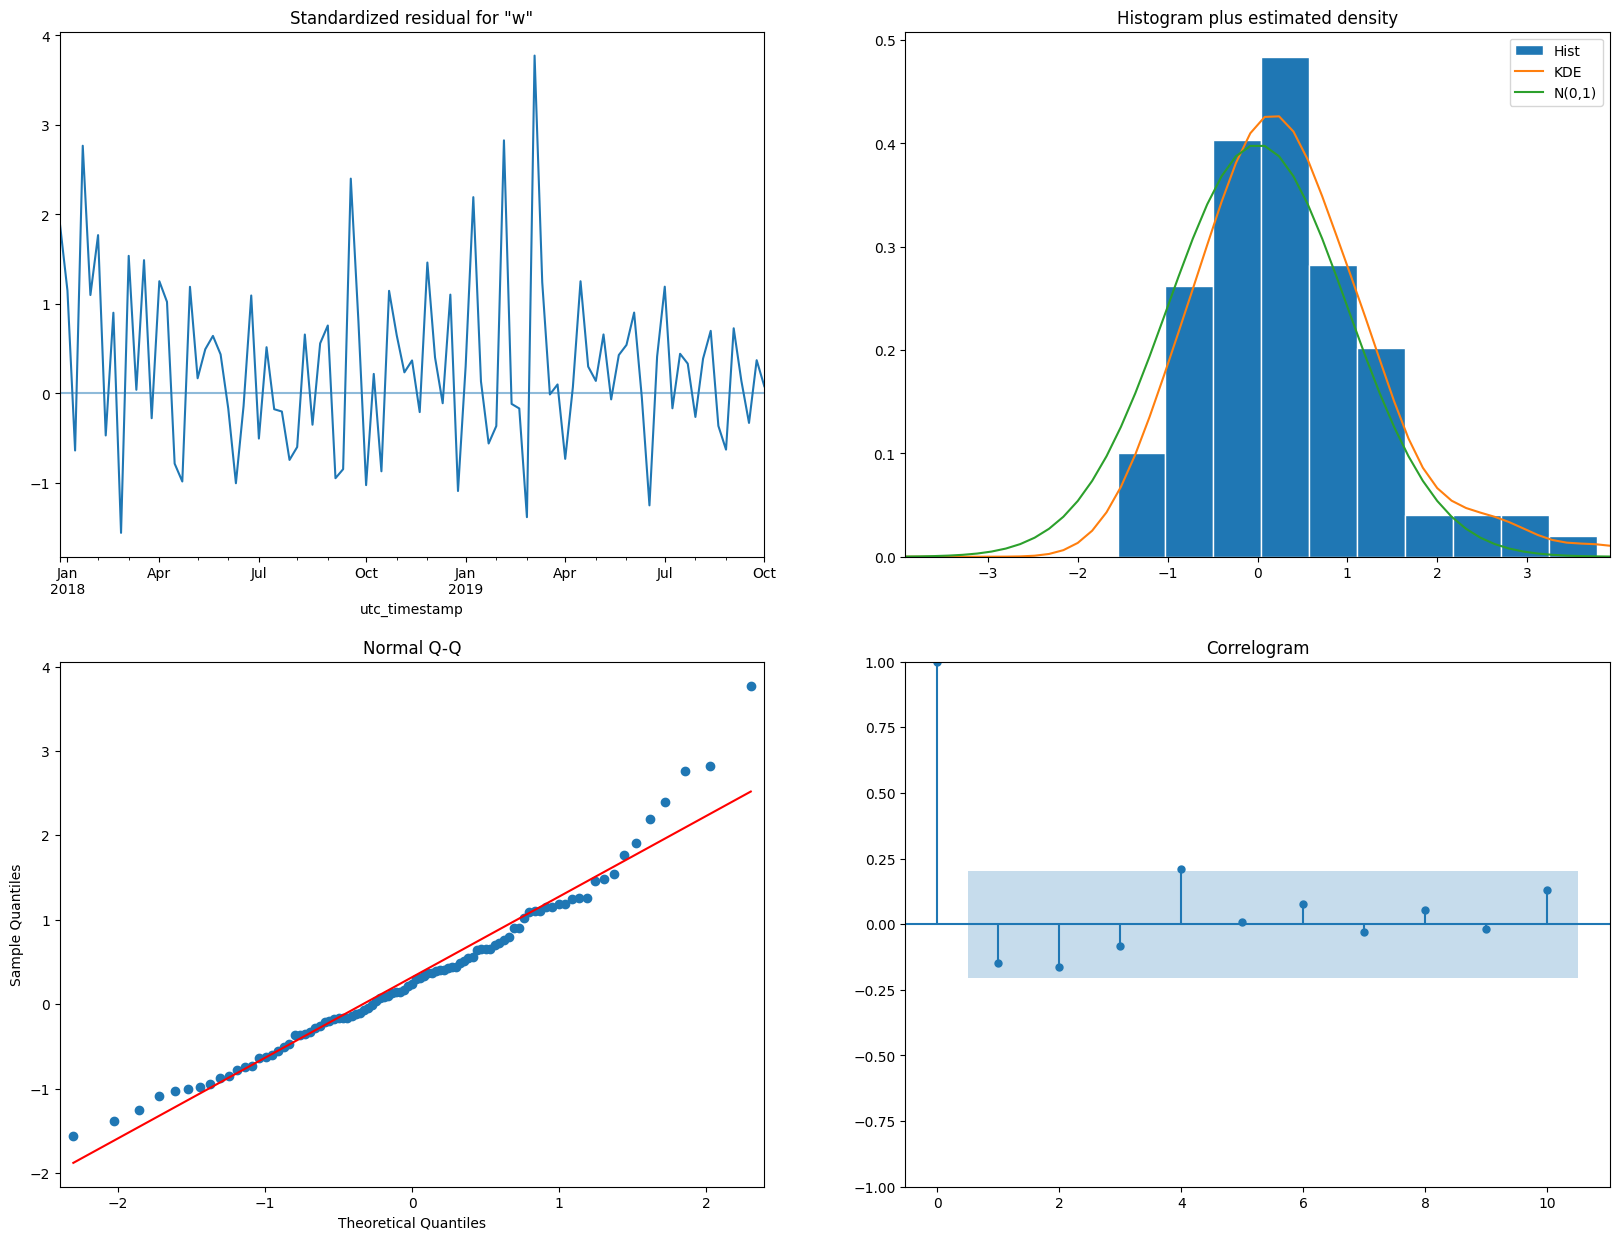

In [62]:
model_SARIMA = SARIMAX(data_train, exog=exog_var_train,
                      order=(p,d,q), 
                       seasonal_order=(P,D,Q,S),
                       enforce_invertibility=False) 
result_SARIMA_exog = model_SARIMA.fit(disp=False)

# Verify the residuals
print(result_SARIMA_exog.summary()) 
result_SARIMA_exog.plot_diagnostics(figsize=(20, 15));

### Residuals test

In [63]:
res = result_SARIMA_exog.resid
dw_res = durbin_watson(res)
print('dw statistic:', dw_res)

dw statistic: 1.1752210190560368


In [64]:
#Another way to study the correlation between the residuals is the Ljung-Box which tests the following:
# H0: The residuals are independently distributed.
# H1: The residuals are not independently distributed; they exhibit serial correlation
ljung_test = acorr_ljungbox(res, period=52)
ljung_test.head()

lb_stat     lb_pvalue
1   4.504421  3.380733e-02
2   7.541151  2.303880e-02
3  15.261332  1.606409e-03
4  33.204984  1.084435e-06
5  36.635435  7.086685e-07

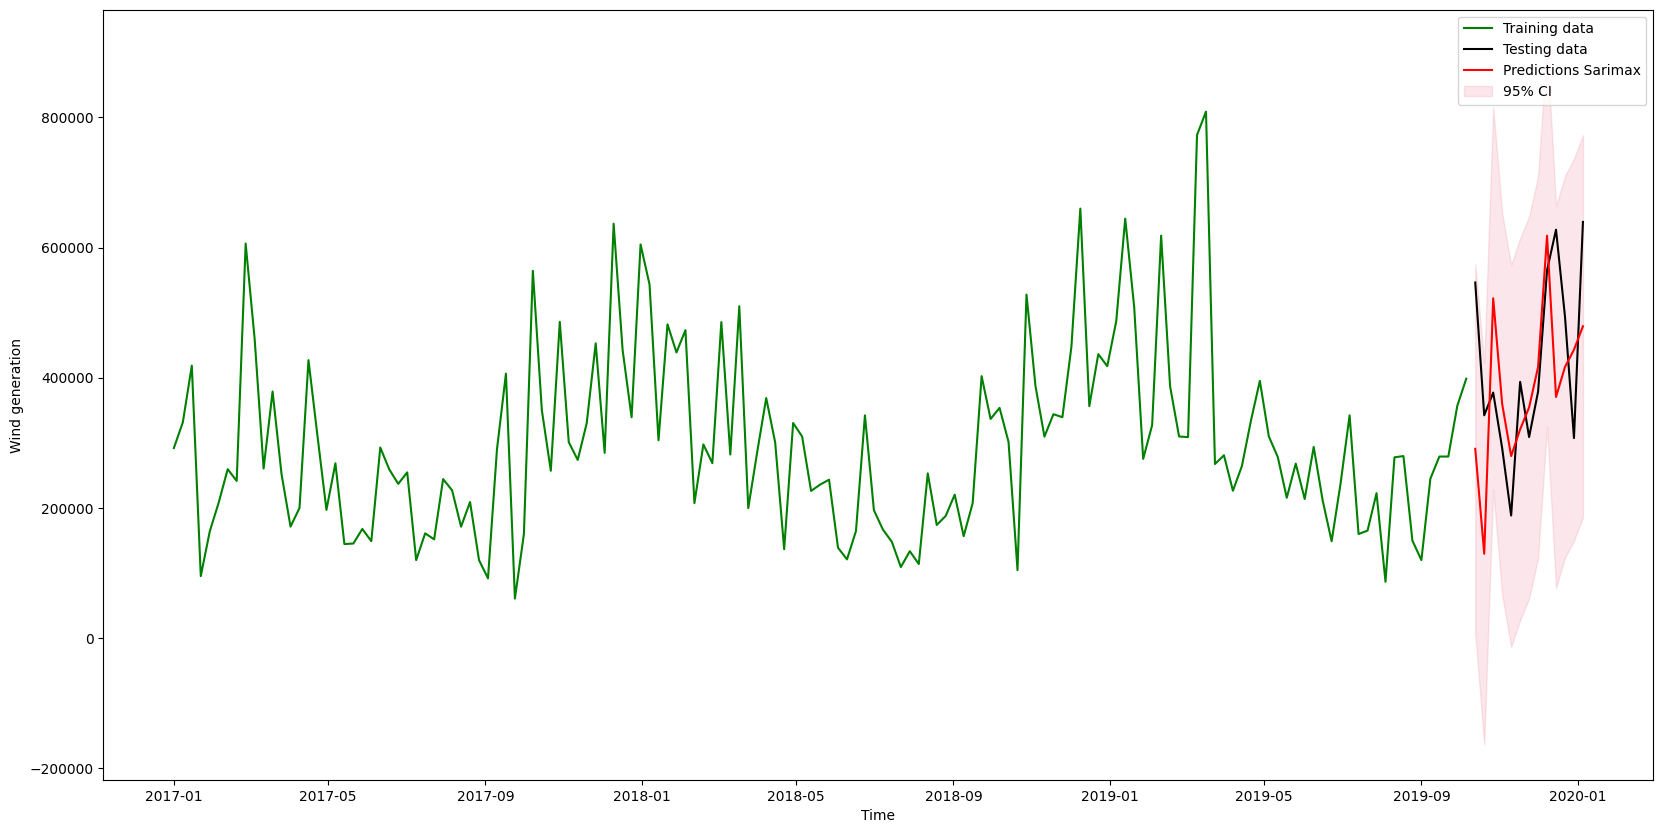

In [65]:
# Forecasting with Manual SARIMAX model - Test set
exog_var_test = pd.concat([temperature_weekly_test], axis=1)
exog_var_test.index = wind_capacity_weeky_test.index
model_SARIMA_exog = result_SARIMA_exog.get_prediction(start=data_test.index[0], end=data_test.index[-1], exog=exog_var_test)
df_manual_exog = model_SARIMA_exog.summary_frame()

plt.figure(figsize=(20, 10)) 
plt.plot(data_train, color='green',label='Training data')
plt.plot(data_test, color='black', label='Testing data')
plt.plot(df_manual_exog['mean'], color='red', label='Predictions Sarimax')
plt.fill_between(df_manual_exog.index, df_manual_exog['mean_ci_lower'], df_manual_exog['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Wind generation')
plt.legend();


In [66]:
sarimax_temp = pd.Series({'Model_name':'Sarimax Temperature', 'AIC':result_SARIMA_exog.aic, 'RMSE': mean_squared_error(data_test, df_manual_exog['mean'], squared=False),
                 'MAE': mean_absolute_error(data_test, df_manual_exog['mean']), 'MAPE':mean_absolute_percentage_error(data_test, df_manual_exog['mean'])})
df_metrics = pd.concat([df_metrics, sarimax_temp.to_frame().T])

## Wind Capacity

Prepare the data

In [67]:
#Sarimax train set
exog_var_train = pd.concat([wind_capacity_weekly_train], axis=1)
exog_var_train.index = wind_capacity_weekly[:-13].index

In [68]:
## Best model
arima_model = auto_arima(data_train,exog_var_train,  start_p=0, start_q=0, d=0,
                           max_p=3, max_q=3, m=52,
                           start_P=0, start_Q=0, max_P = 3, max_Q = 3, D = 1, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',  
                           suppress_warnings=True, 
                           n_jobs=4,
                           stepwise=True)

NameError: name 'auto_arima' is not defined

In [69]:
(p, d, q ) = (0,0,1)
(P, D, Q) = (1,1,0) 

                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                  145
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 52)   Log Likelihood               -1226.214
Date:                             Thu, 01 Feb 2024   AIC                           2460.428
Time:                                     18:57:24   BIC                           2470.558
Sample:                                 01-01-2017   HQIC                          2464.518
                                      - 10-06-2019                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
wind_capacity     6.4478      1.015      6.353      0.000       4.459       8.437
ma.L1             

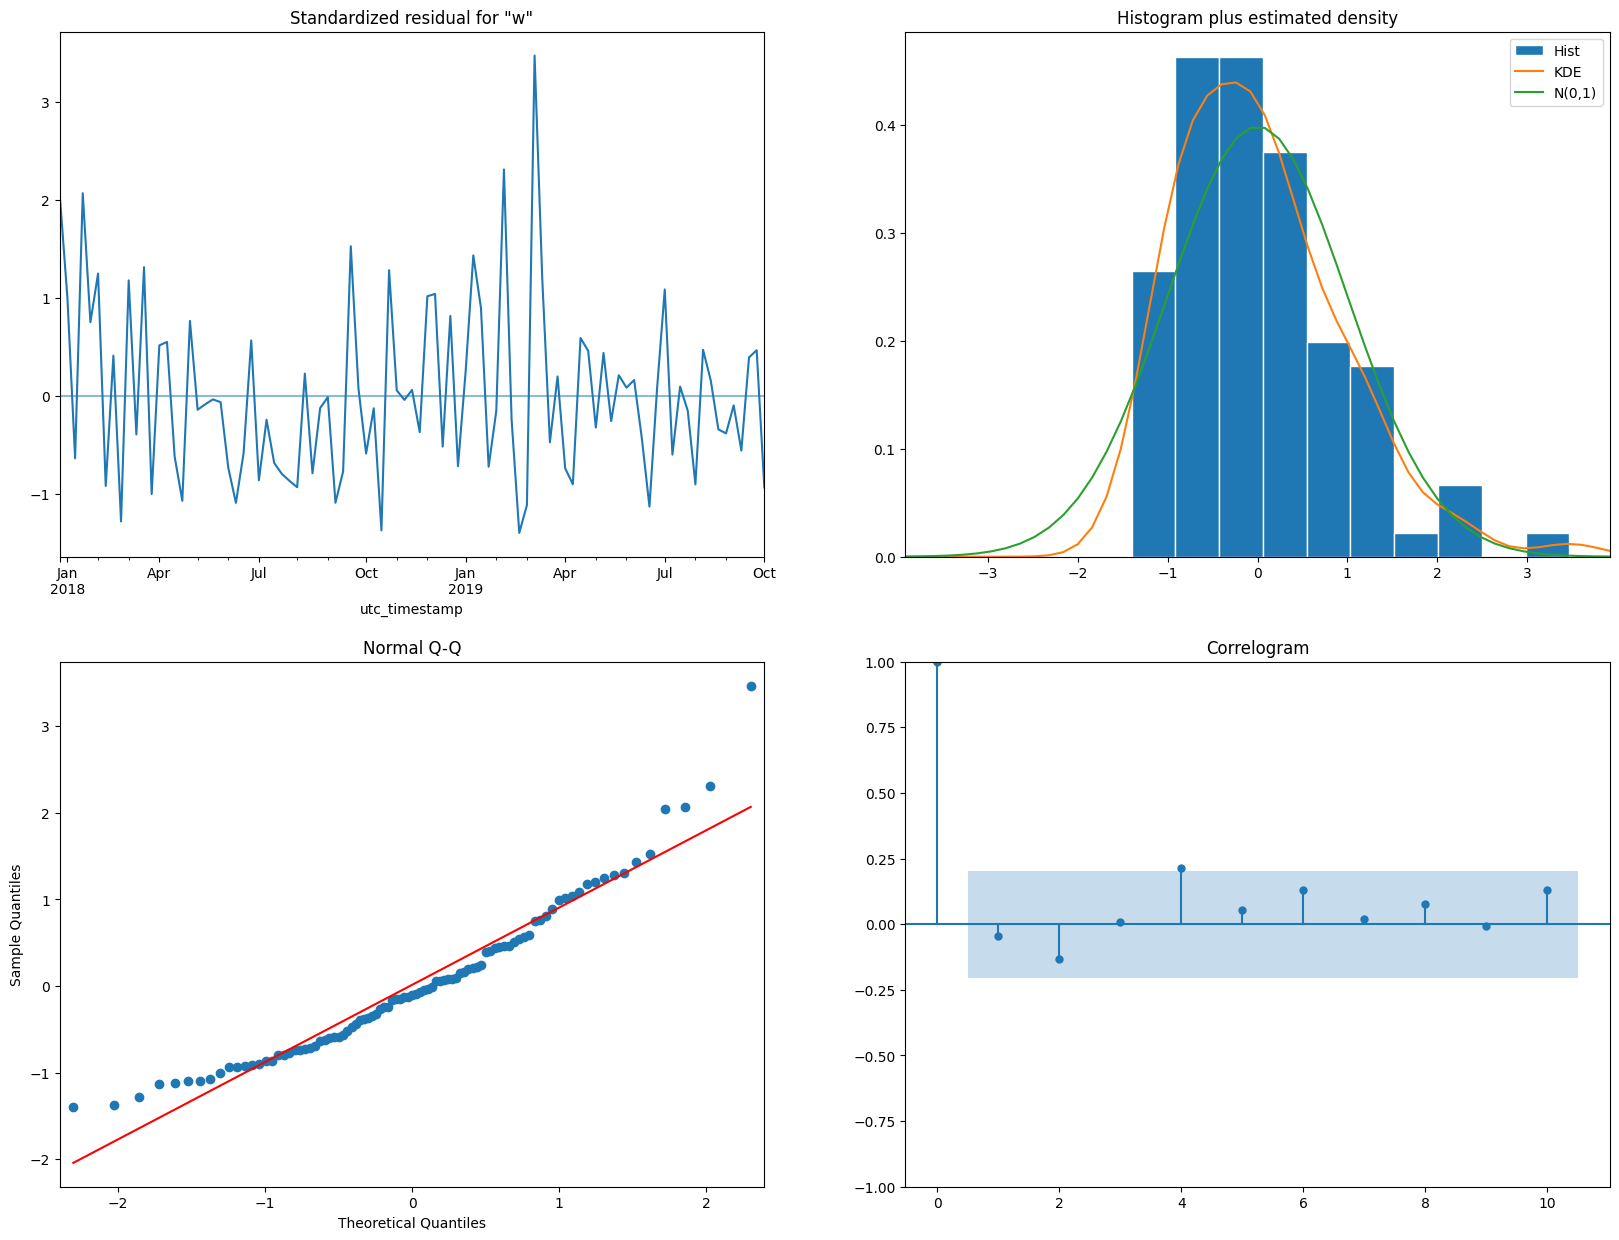

In [70]:
model_SARIMA = SARIMAX(data_train, exog=exog_var_train,
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,S),
                       enforce_invertibility=False) 
result_SARIMA_exog_wind = model_SARIMA.fit(disp=False)

# Verify the residuals
print(result_SARIMA_exog_wind.summary()) 
result_SARIMA_exog_wind.plot_diagnostics(figsize=(20, 15));

### Residuals

In [71]:
#Test for the Durbin Watson
res = result_SARIMA_exog_wind.resid
dw_res = durbin_watson(res)
print('dw statistic:', dw_res)

dw statistic: 2.0093330147698865


In [72]:
ljung_test = acorr_ljungbox(res, period=52)
ljung_test.head()

lb_stat  lb_pvalue
1  0.022649   0.880374
2  1.081962   0.582177
3  4.138807   0.246860
4  9.648872   0.046777
5  9.778769   0.081752

### Forecast

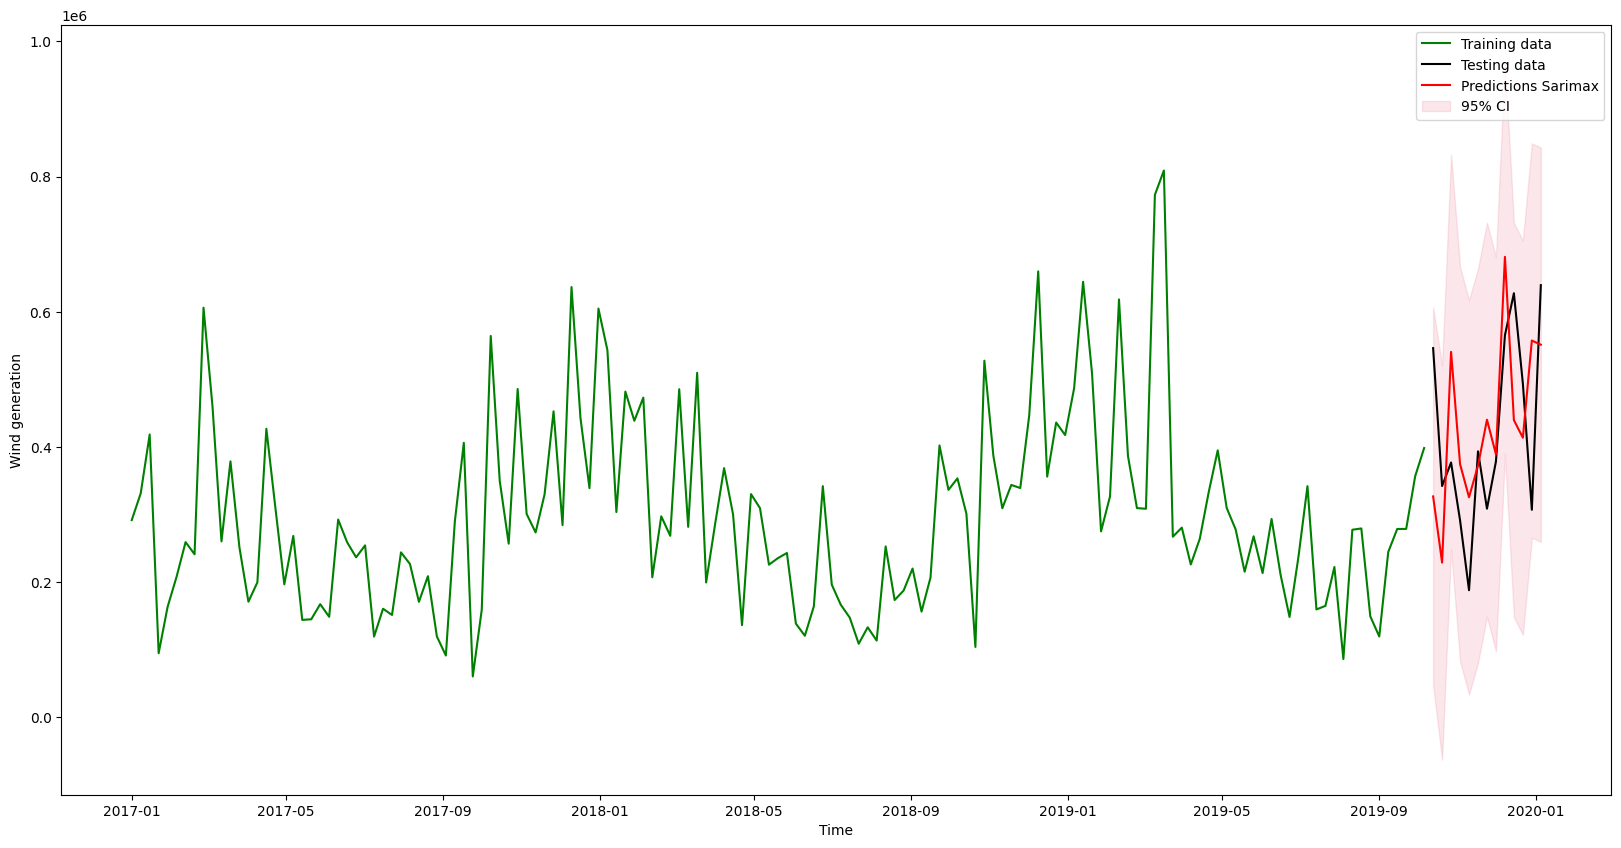

In [73]:
# Forecasting with Manual SARIMAX model - Test set
exog_var_test = pd.concat([wind_capacity_weeky_test], axis=1)
exog_var_test.index = wind_capacity_weeky_test.index
model_SARIMA_exog_wind = result_SARIMA_exog_wind.get_prediction(start=data_test.index[0], end=data_test.index[-1], exog=exog_var_test)
df_manual_exog_wind = model_SARIMA_exog_wind.summary_frame()

plt.figure(figsize=(20, 10)) 
plt.plot(data_train, color='green',label='Training data')
plt.plot(data_test, color='black', label='Testing data')
plt.plot(df_manual_exog_wind['mean'], color='red', label='Predictions Sarimax')
plt.fill_between(df_manual_exog_wind.index, df_manual_exog_wind['mean_ci_lower'], df_manual_exog_wind['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Wind generation')
plt.legend();


In [74]:
sarimax_wind = pd.Series({'Model_name':'Sarimax Wind Capacity', 'AIC':result_SARIMA_exog_wind.aic, 'RMSE': mean_squared_error(data_test, df_manual_exog_wind['mean'], squared=False),
                 'MAE': mean_absolute_error(data_test, df_manual_exog_wind['mean']), 'MAPE':mean_absolute_percentage_error(data_test, df_manual_exog_wind['mean'])})
df_metrics = pd.concat([df_metrics, sarimax_wind.to_frame().T])

## Wind Capacity And Temperature

In [75]:
#Prepare the exogenous vector
exog_var_train = pd.concat([temperature_weekly_train, wind_capacity_weekly_train], axis=1)
exog_var_train.index = wind_capacity_weekly[:-13].index

In [ ]:
## Best model, DO NOT RUN!!!
arima_model = auto_arima(y = data_train, X = exog_var_train,  start_p=0, start_q=0, d=0,
                           max_p=3, max_q=3, m=52,
                           start_P=0, start_Q=0, max_P = 3, max_Q = 3, D = 1, seasonal=True,
                           trace=True, information_criterion='bic',
                           error_action='ignore',  
                           suppress_warnings=True, 
                           n_jobs=4,
                           stepwise=True)

In [76]:
(p, d, q ) = (0,0,1)
(P, D, Q) = (1,1,0) 

                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                  145
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 52)   Log Likelihood               -1228.043
Date:                             Thu, 01 Feb 2024   AIC                           2466.087
Time:                                     18:59:12   BIC                           2478.750
Sample:                                 01-01-2017   HQIC                          2471.200
                                      - 10-06-2019                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
temperature    3802.9001   4401.625      0.864      0.388   -4824.127    1.24e+04
wind_capacity     

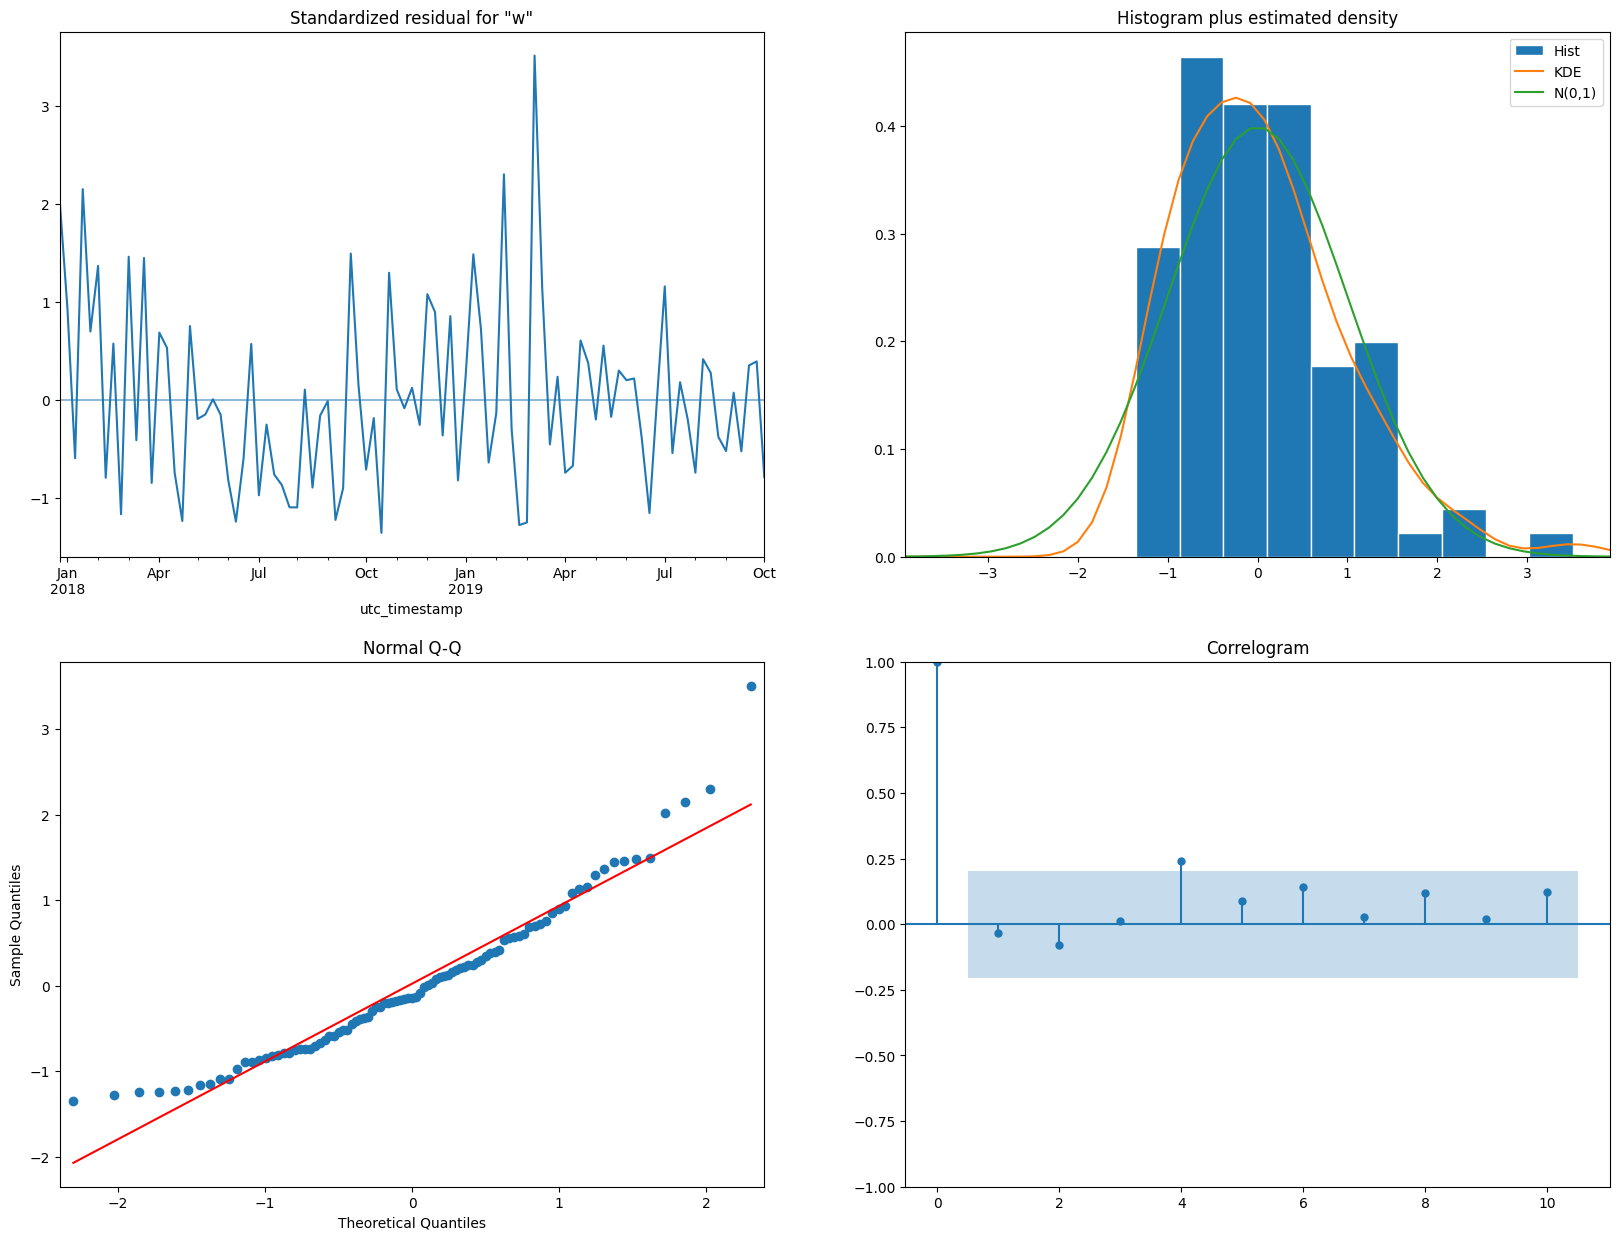

In [77]:
##Create the model with the parameter (p,d,q)(P,D,Q) equals to the sarima
model_SARIMA = SARIMAX(data_train, exog=exog_var_train,
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,S),
                       enforce_invertibility=False) 
#Fit the model
result_SARIMA_exog_all = model_SARIMA.fit(disp=False)

# Verify the residuals
print(result_SARIMA_exog_all.summary()) 
result_SARIMA_exog_all.plot_diagnostics(figsize=(20, 15));

We want to make sure each term in our model is statistically significant. The null for this section is that each coefficient is NOT statistically significant. Therefore, we want each term to have a p-value of less than 0.05, so we can reject the null hypothesis with statistically significant values.

### Residuals

In [78]:
res = result_SARIMA_exog_all.resid
dw_res = durbin_watson(res)
print('dw statistic:', dw_res)
#The Durbin-Watson test shows that there is little to no correlation of the residuals. 


dw statistic: 1.9076519071277376


In [79]:
#Another way to study the correlation between the residuals is the Ljung-Box which tests the following:
# H0: The residuals are independently distributed.
# H1: The residuals are not independently distributed; they exhibit serial correlation
ljung_test = acorr_ljungbox(res, period=52)
ljung_test.head()

lb_stat  lb_pvalue
1   0.221689   0.637756
2   0.225833   0.893225
3   4.549119   0.207951
4  13.169829   0.010475
5  13.342905   0.020369

### Forecast

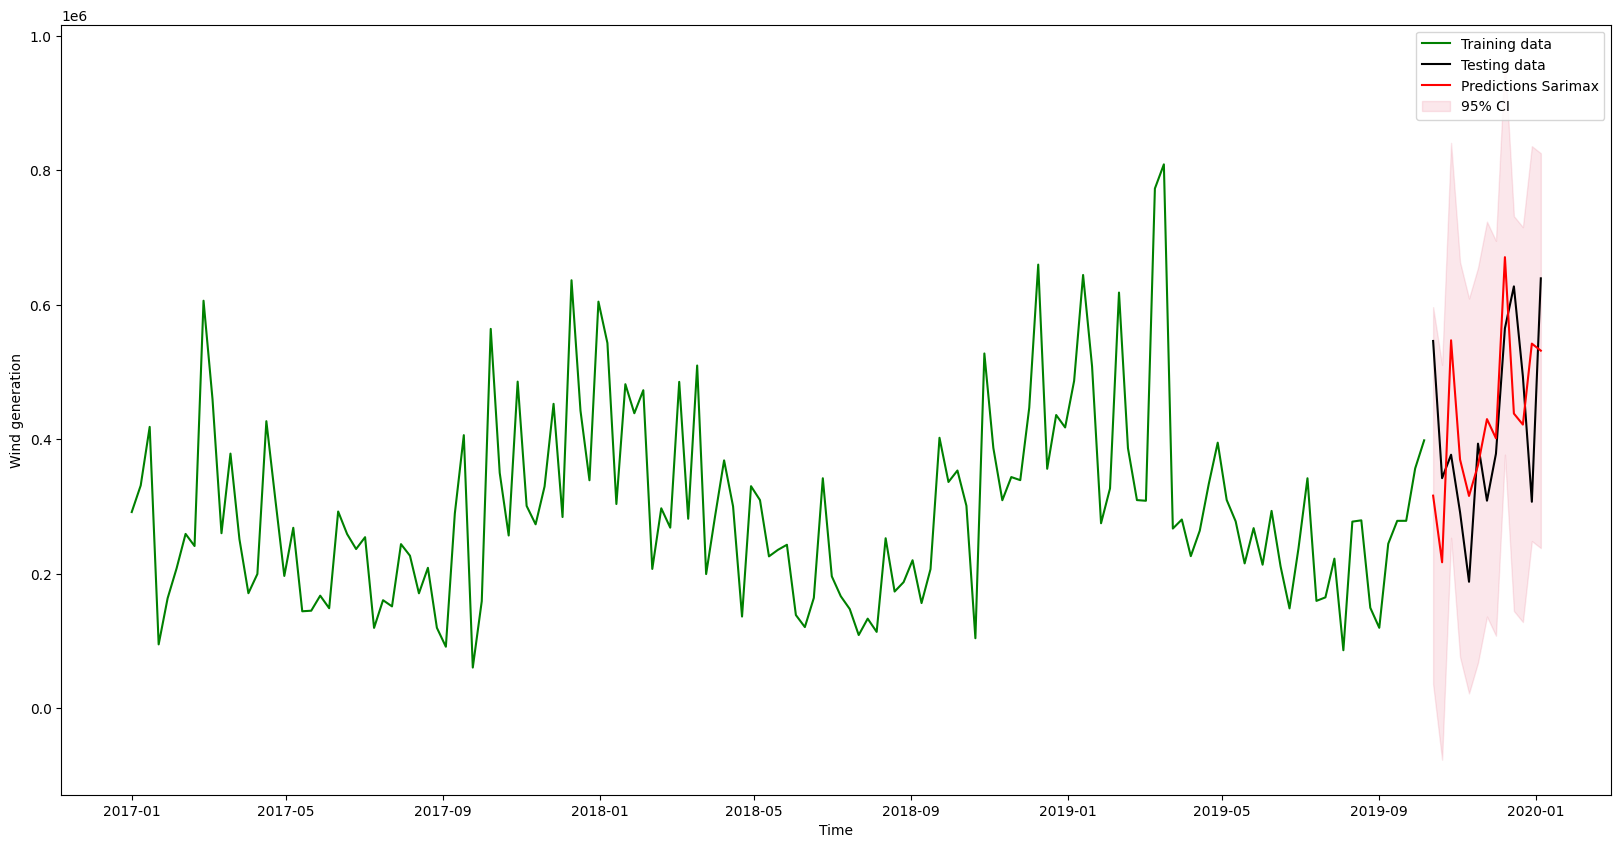

In [80]:
# Forecasting with Manual SARIMAX model - Test set
exog_var_test = pd.concat([temperature_weekly_test, wind_capacity_weeky_test], axis=1)
exog_var_test.index = wind_capacity_weeky_test.index
model_SARIMA_exog_all = result_SARIMA_exog_all.get_prediction(start=data_test.index[0], end=data_test.index[-1], exog=exog_var_test)
df_sarimax_features_all = model_SARIMA_exog_all.summary_frame()

plt.figure(figsize=(20, 10)) 
plt.plot(data_train, color='green',label='Training data')
plt.plot(data_test, color='black', label='Testing data')
plt.plot(df_sarimax_features_all['mean'], color='red', label='Predictions Sarimax')
plt.fill_between(df_sarimax_features_all.index, df_sarimax_features_all['mean_ci_lower'], df_sarimax_features_all['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Wind generation')
plt.legend();


In [81]:
sarimax_all = pd.Series({'Model_name':'Sarimax All', 'AIC':result_SARIMA_exog_all.aic, 'RMSE': mean_squared_error(data_test, df_sarimax_features_all['mean'], squared=False),
                 'MAE': mean_absolute_error(data_test, df_sarimax_features_all['mean']), 'MAPE':mean_absolute_percentage_error(data_test, df_sarimax_features_all['mean'])})
df_metrics = pd.concat([df_metrics, sarimax_all.to_frame().T])

# ETS

Exponential smoothing was proposed in the late 1950s (Brown, 1959; Holt, 1957; Winters, 1960), and has motivated some of the most successful forecasting methods. Forecasts produced using exponential smoothing methods (generally known as "ETS models", where E indicates error, T trend and S seasonality) are weighted averages of past observations, with the weights decaying exponentially as the observations get older. Briefly, the more recent the observation is, the higher the associated weight. This framework generates reliable forecasts quickly and for a wide range of time series, which is a great advantage and of major importance to applications in industry. \\
Note: In Python, ETS model parameters are selected as maximizers of log likelihood.

## Daily Data

In [82]:
d_test_ets = df_completed['wind_generation_actual']
d_train_ets = df_completed['wind_generation_actual'][:'12-01-2019']
d_test_ets = df_completed['wind_generation_actual']['12-01-2019':]

### Search for the best seasonality

In [ ]:
# Do not run, otherwise it'll take some time to the complete the computations.
best_map = 100
best_i = 0
for i in range(2,300):
    model_1 = ETSModel(df_completed['wind_generation_actual'], trend='add', seasonal='add',seasonal_periods=i).fit()
    pred_1 = model_1.get_prediction(start=d_test_ets.index[0], end=d_test_ets.index[-1])
    df_1 = pred_1.summary_frame()
    map = mean_absolute_percentage_error(d_test_ets, df_1['mean'])
    if(map < best_map):
        best_map = map
        best_i = i


We find out (after two hours of fittings) that the best seasonal period using the MAP as metrics for the ETS is 21.

In [83]:
model_ETS_21 = ETSModel(df_completed['wind_generation_actual'], trend='add', seasonal='add',seasonal_periods=21).fit(disp=False)
pred_ETS_21 = model_ETS_21.get_prediction(start=d_test_ets.index[0], end=d_test_ets.index[-1])
df_ETS_21 = pred_ETS_21.summary_frame()

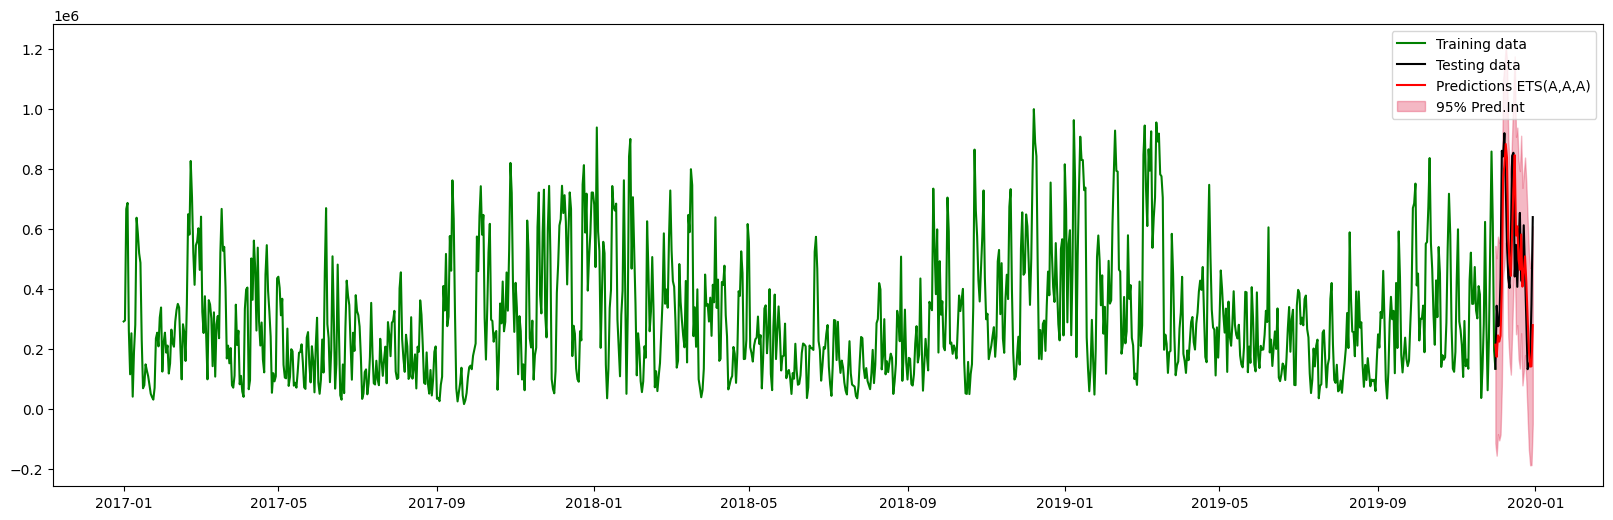

In [84]:
fig = plt.figure(figsize=(20,6))
plt.plot(d_train_ets, color='green',label='Training data')
plt.plot(d_test_ets, color='black', label='Testing data')
plt.plot(df_ETS_21['mean'], color='red', label='Predictions ETS(A,A,A)')
plt.fill_between(df_ETS_21.index, df_ETS_21['pi_lower'], df_ETS_21['pi_upper'], alpha=.3, color='crimson', label='95% Pred.Int')
plt.legend();


In [85]:
ets_21 = pd.Series({'Model_name':'ETS Daily 21', 'AIC':model_ETS_21.aic, 'RMSE': mean_squared_error(d_test_ets, df_ETS_21['mean'], squared=False),
                 'MAE': mean_absolute_error(d_test_ets, df_ETS_21['mean']), 'MAPE':mean_absolute_percentage_error(d_test_ets, df_ETS_21['mean'])})
df_metrics = pd.concat([df_metrics, ets_21.to_frame().T])

### Seasonality of 365

### Create the model

In [86]:
model_1 = ETSModel(df_completed['wind_generation_actual'], trend='add', seasonal='add',seasonal_periods=365).fit(disp=False)
pred_1 = model_1.get_prediction(start=d_test_ets.index[0], end=d_test_ets.index[-1])
df_ETS = pred_1.summary_frame()

### Forecast

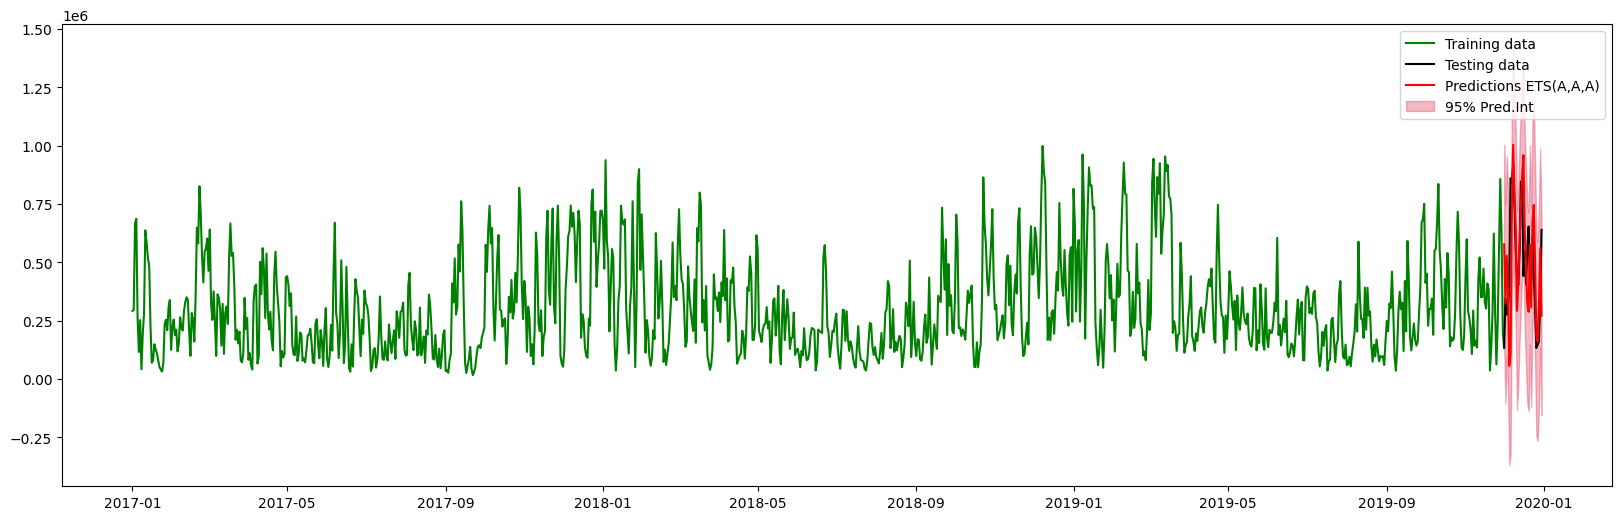

In [87]:
fig = plt.figure(figsize=(20,6))
plt.plot(d_train_ets, color='green',label='Training data')
plt.plot(d_test_ets, color='black', label='Testing data')
plt.plot(df_ETS['mean'], color='red', label='Predictions ETS(A,A,A)')
plt.fill_between(df_ETS.index, df_ETS['pi_lower'], df_ETS['pi_upper'], alpha=.3, color='crimson', label='95% Pred.Int')
plt.legend();


In [88]:
ets_365 = pd.Series({'Model_name':'ETS Daily 365', 'AIC':model_1.aic, 'RMSE': mean_squared_error(d_test_ets, df_ETS['mean'], squared=False),
                 'MAE': mean_absolute_error(d_test_ets, df_ETS['mean']), 'MAPE':mean_absolute_percentage_error(d_test_ets, df_ETS['mean'])})
df_metrics = pd.concat([df_metrics, ets_365.to_frame().T])

# Weekly Data

The ETS can handle big values for the seasonality, but for a fair comparison between the models i've decided to try the ETS on the weekly data too. I've chosen the seasonal period of 52 which is used for the Sarima family.

### Create the model

In [89]:
model_ETS_Week = ETSModel(data_train, trend='add', seasonal='add',seasonal_periods=52).fit(disp=False)
pred_ETS_Week = model_ETS_Week.get_prediction(start=data_test.index[0], end=data_test.index[-1])
df_ETS_Week = pred_ETS_Week.summary_frame()

### Forecast

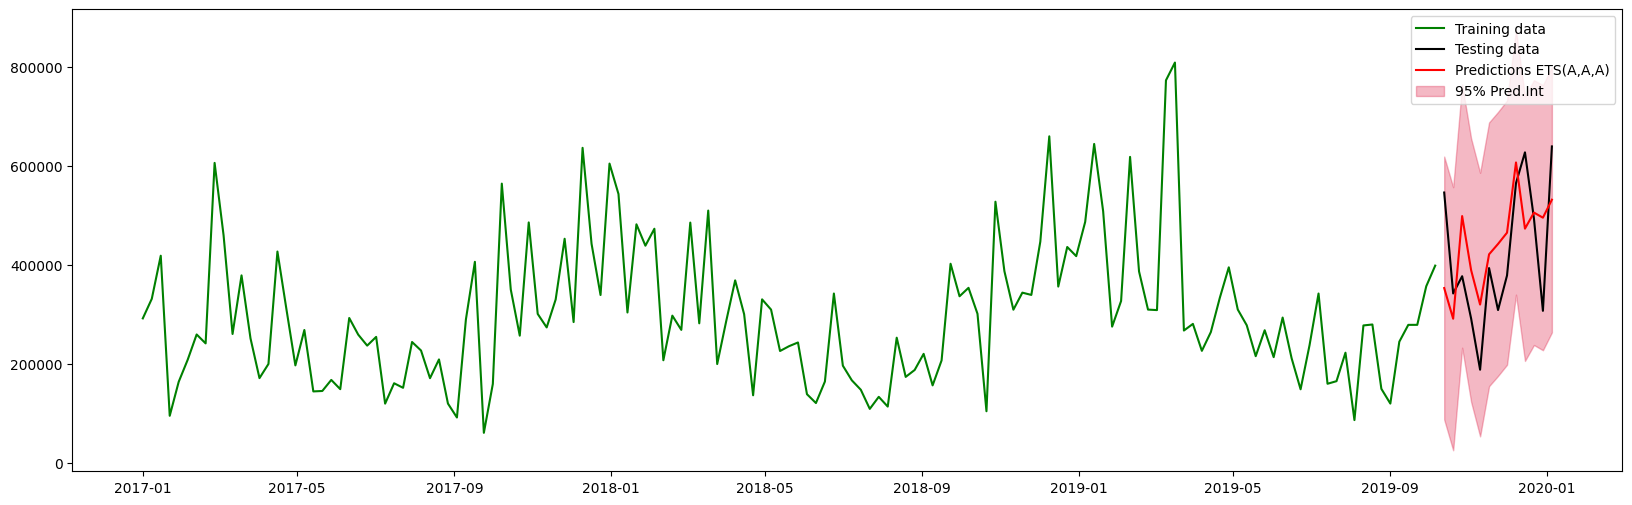

In [90]:
fig = plt.figure(figsize=(20,6))
plt.plot(data_train, color='green',label='Training data')
plt.plot(data_test, color='black', label='Testing data')
plt.plot(df_ETS_Week['mean'], color='red', label='Predictions ETS(A,A,A)')
plt.fill_between(df_ETS_Week.index, df_ETS_Week['pi_lower'], df_ETS_Week['pi_upper'], alpha=.3, color='crimson', label='95% Pred.Int')
plt.legend();


In [91]:
ets_weekly = pd.Series({'Model_name':'ETS Weekly 52', 'AIC':model_ETS_Week.aic, 'RMSE': mean_squared_error(data_test, df_ETS_Week['mean'], squared=False),
                 'MAE': mean_absolute_error(data_test, df_ETS_Week['mean']), 'MAPE':mean_absolute_percentage_error(data_test, df_ETS_Week['mean'])})
df_metrics = pd.concat([df_metrics, ets_weekly.to_frame().T])

# Vector autoregressive model

One limitation of the models that we have considered so far is that they impose a unidirectional relationship, that is the forecast variable is influenced by the predictor variables, but not vice versa. We have seen how to incorporate, for example with SARIMAX models, the impact of exogenous variables on a time series. However, such relationship is unidirectional, thus we assume that the exogenous variable has an impact on the target only. 

## Splitting data

In [92]:
data = df_completed[['temperature','wind_generation_actual']]
data_train_VAR = df_completed[['temperature','wind_generation_actual']][:'2019-12-01']
data_test_VAR = df_completed[['temperature','wind_generation_actual']]['2019-12-01':]

We know that after differencing the yearly seasonality the dataset is stationary, so let's do that again and then get the train set diffed.

In [93]:
data_train_diff_VAR = data_train_VAR.diff(365).dropna()

## Stationary test

In this case we have to check that other than wind_generation_actual, the temperature and the wind capacity have to be stationary and so we can get this information from the ADFuller and KPSS tests which we've already widely used.

In [94]:
print('Temperature stationary test')
adfuller_test(data_train_diff_VAR.temperature)
kpss_test(data_train_diff_VAR.temperature)
print(50*'*')
print('Wind generation stationary test')
adfuller_test(data_train_diff_VAR.wind_generation_actual)
kpss_test(data_train_diff_VAR.wind_generation_actual)
print(50*'*')


Temperature stationary test
ADF Statistic: -5.053942567316218
p-value:  1.7337878753909385e-05
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
We can reject the null hypothesis (H0) --> data is stationary
KPSS Statistic: 0.0538202087631208
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
**************************************************
Wind generation stationary test
ADF Statistic: -13.767585382019107
p-value:  9.818651975747313e-26
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
We can reject the null hypothesis (H0) --> data is stationary
KPSS Statistic: 0.06629966536456999
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
**************************************************


## Granger Causality

Granger causality test on stationary signals (thus on the differenced data)
This test helps us validating the hypothesis that two time series impact on each other.
If a variable X is found to be helpful for predicting another variable Y, then X is said to Granger-cause Y; otherwise it
is said to fail to Granger-cause Y.
So a variable X Granger-causes another variable Y if Y's predictions based on its own past values and on the past values of X are better than Y's predictions based only on Y's past values

In [95]:
from statsmodels.tsa.stattools import grangercausalitytests
print('wind_generation_actual Granger-causes temperature?')
print('------------------')
granger_1 = grangercausalitytests(data_train_diff_VAR[['temperature', 'wind_generation_actual']], maxlag=20)
 
print('\ntemperature Granger-causes wind_generation_actual?')
print('------------------')
granger_2 = grangercausalitytests(data_train_diff_VAR[['wind_generation_actual', 'temperature']],maxlag=20)
#Temperature does not cause granger causality on the wind_generation actual, but the other way yes, so let's give a try

wind_generation_actual Granger-causes temperature?
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6833  , p=0.0033  , df_denom=696, df_num=1
ssr based chi2 test:   chi2=8.7207  , p=0.0031  , df=1
likelihood ratio test: chi2=8.6668  , p=0.0032  , df=1
parameter F test:         F=8.6833  , p=0.0033  , df_denom=696, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4634  , p=0.0044  , df_denom=693, df_num=2
ssr based chi2 test:   chi2=11.0056 , p=0.0041  , df=2
likelihood ratio test: chi2=10.9197 , p=0.0043  , df=2
parameter F test:         F=5.4634  , p=0.0044  , df_denom=693, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2107  , p=0.0058  , df_denom=690, df_num=3
ssr based chi2 test:   chi2=12.7603 , p=0.0052  , df=3
likelihood ratio test: chi2=12.6449 , p=0.0055  , df=3
parameter F test:         F=4.2107  , p=0.0058  , df_denom=690, df_num=3

Granger Causality
numbe

Let's determine the best value for the parameter p of the VAR. There are two ways: choosing by the select_order function or do a grid search and detect which p is the best. I've decided to do both and then confront them

In [100]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [96]:
# Automatic VAR model
model = VAR(data_train_diff_VAR)
x = model.select_order(maxlags=6)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [99]:
results = []
for p in range(1,6,1):
        model = VARMAX(data_train_diff_VAR, order=(p,0)).fit(disp=False)
        aic = model.aic
        results.append([p, aic])
        
result_df = pd.DataFrame(results)
result_df.columns = ['p', 'AIC']
opt = result_df[result_df['AIC']==result_df['AIC'].min()]
display(opt)

p          AIC
2  3  22214.72696

In [97]:
# The best model is 3
p = 3

In [101]:
# Fit the optimal VAR model
best_model_VAR = VARMAX(data_train_diff_VAR, order=(3,0)).fit(disp=False)
print(best_model_VAR.summary())

                                       Statespace Model Results                                      
Dep. Variable:     ['temperature', 'wind_generation_actual']   No. Observations:                  700
Model:                                                VAR(3)   Log Likelihood              -11090.363
                                                 + intercept   AIC                          22214.727
Date:                                       Thu, 01 Feb 2024   BIC                          22292.095
Time:                                               19:04:35   HQIC                         22244.634
Sample:                                           01-01-2018                                         
                                                - 12-01-2019                                         
Covariance Type:                                         opg                                         
Ljung-Box (L1) (Q):             0.05, 0.00   Jarque-Bera (JB):           3.07, 4.2

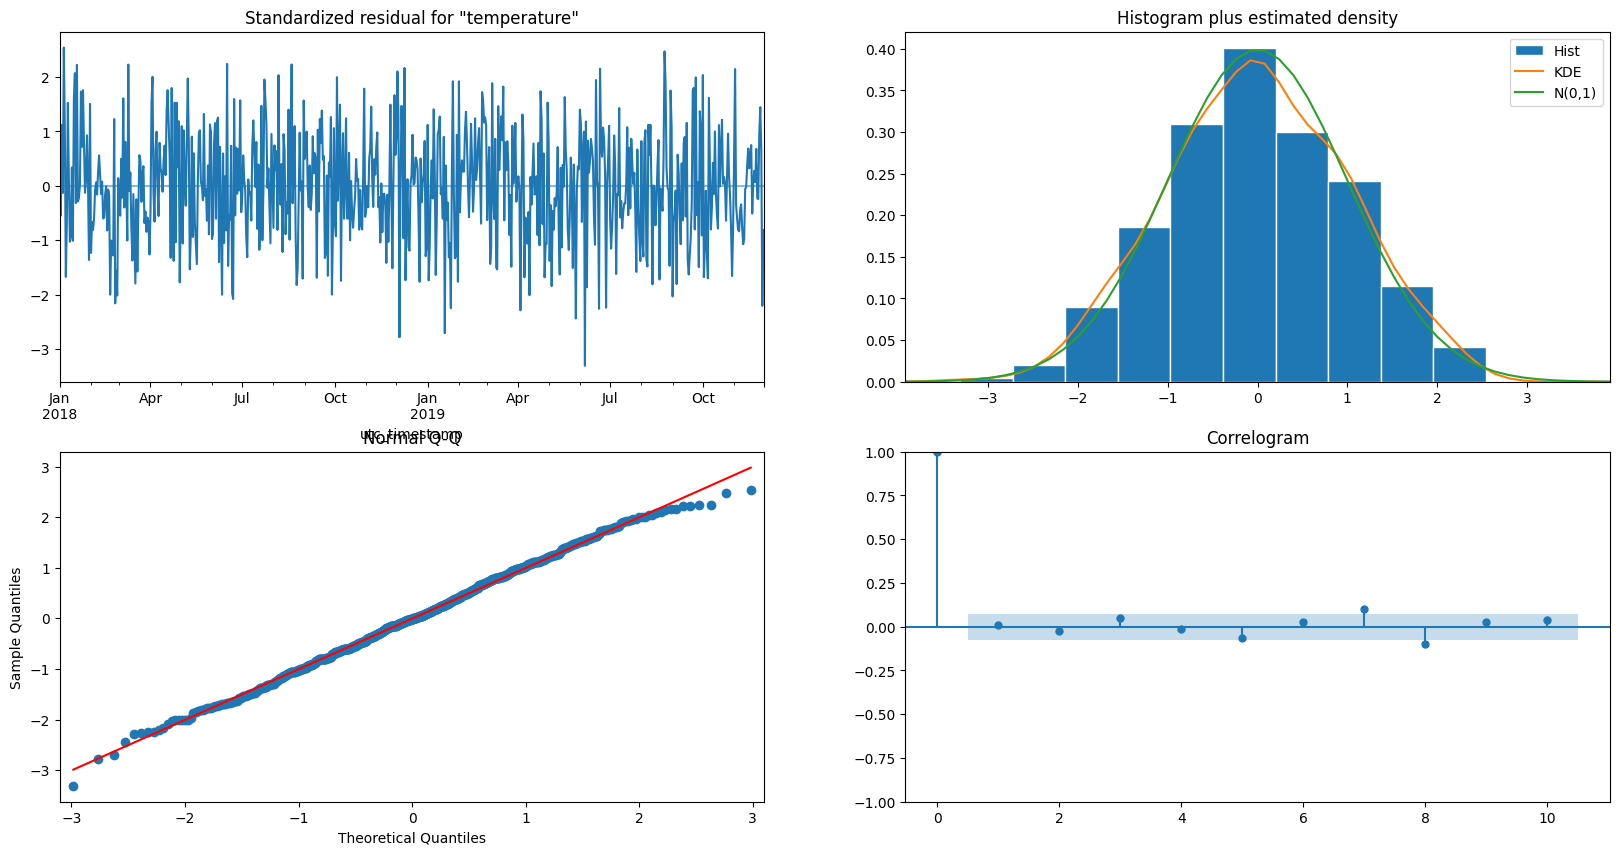

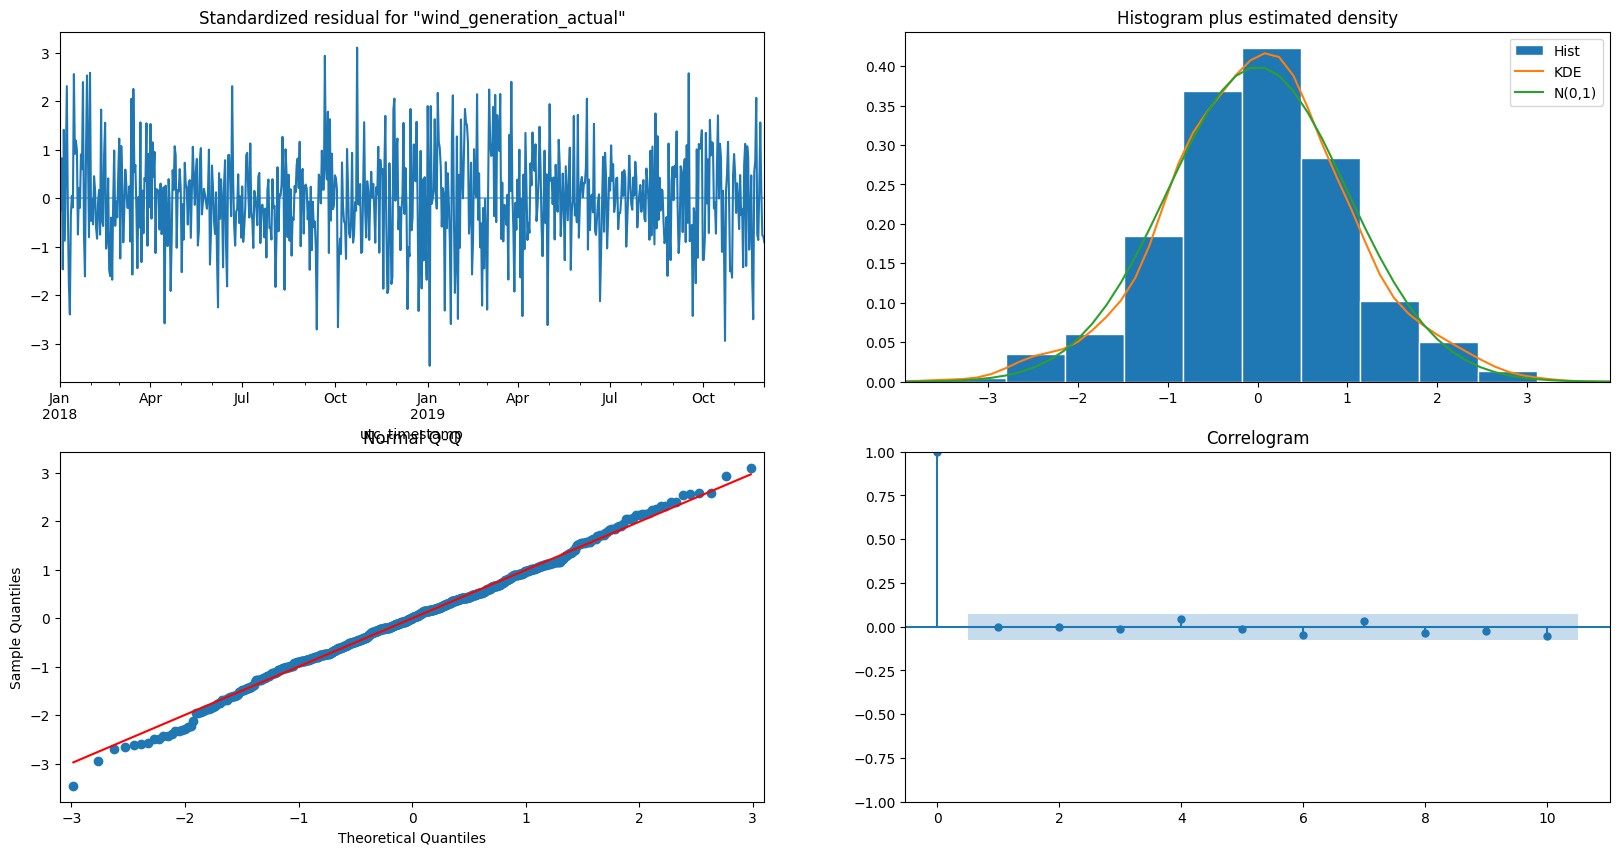

In [102]:
# Plot diagnostic for realdpi
best_model_VAR.plot_diagnostics(figsize=(20,10), variable=0);

# Plot diagnostic for realcons
best_model_VAR.plot_diagnostics(figsize=(20,10), variable=1);

In [103]:
# Forecast
predictions = best_model_VAR.get_prediction(start=data_test_VAR.index[0], end=data_test_VAR.index[-1])
oos_pred_temperature = predictions.predicted_mean['temperature']
oos_pred_wind_generation_actual = predictions.predicted_mean['wind_generation_actual']

In [104]:
from datetime import timedelta
def invert_transformation(df_train):
     forecasting =  pd.DataFrame(columns=['wind_generation_actual']) #data_test
     df_fc = predictions.predicted_mean.wind_generation_actual
     ls = dict()
     for idx in df_fc.index:
          value = df_train[idx - timedelta(365)] + (df_fc[idx])
          ls[idx] = value
     forecasting = pd.DataFrame(ls.items(),columns=['date_time','wind_generation_actual'])
     forecasting.index = forecasting.date_time
     forecasting.drop('date_time', inplace=True, axis=1)
     return forecasting
df_results = invert_transformation(data_train_VAR.wind_generation_actual)

Text(0, 0.5, 'Wind generation actual')

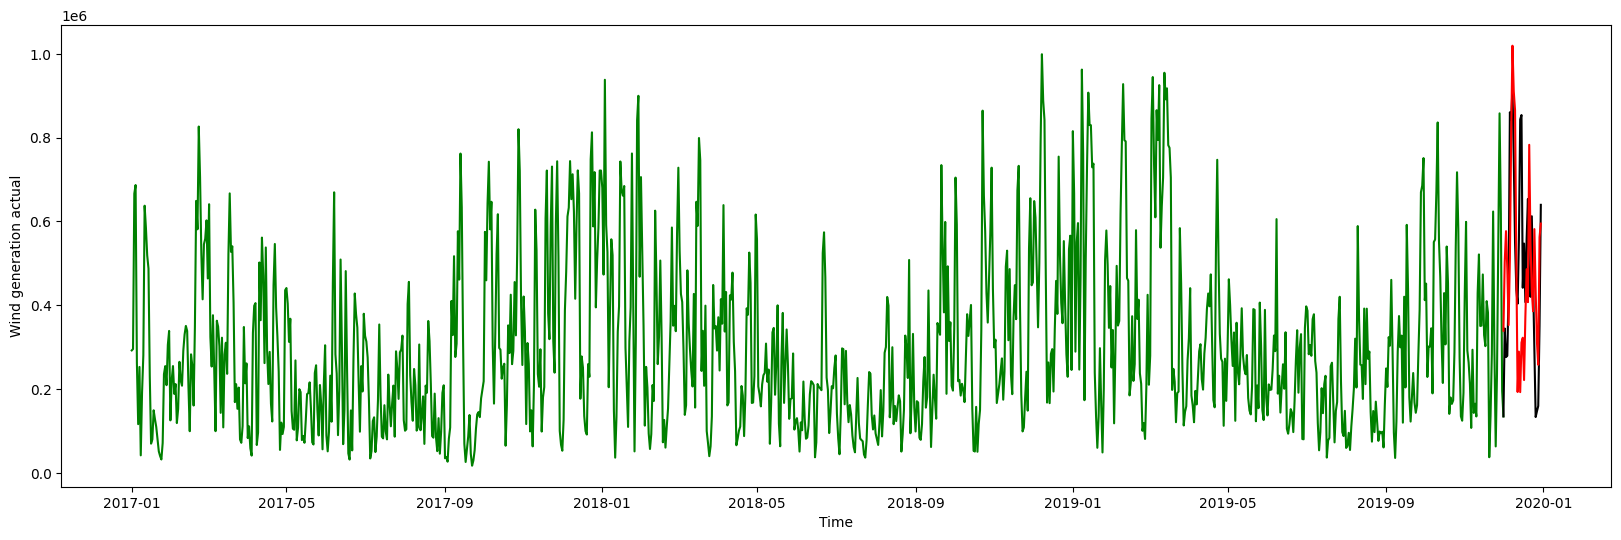

In [105]:
# Visualize the results
plt.figure(figsize=(20,6))
plt.plot(data_train_VAR.wind_generation_actual,'green')
plt.plot(data_test_VAR.wind_generation_actual,'black')
plt.plot(df_results,'-r')
plt.xlabel('Time')
plt.ylabel('Wind generation actual')


In [106]:
df_VAR = pd.Series({'Model_name':'VAR', 'AIC':best_model_VAR.aic, 'RMSE': mean_squared_error(data_test_VAR.wind_generation_actual, df_results, squared=False),
                 'MAE': mean_absolute_error(data_test_VAR.wind_generation_actual, df_results), 'MAPE':mean_absolute_percentage_error(data_test_VAR.wind_generation_actual, df_results)})
df_metrics = pd.concat([df_metrics, df_VAR.to_frame().T])

# Best model

In [107]:
df_metrics.index = df_metrics.Model_name
df_metrics.drop(['Model_name'], inplace=True, axis=1)

In [108]:
df_metrics

AIC            MAE           RMSE      MAPE
Model_name                                                                 
Sarima Manual           2484.260831  138072.580819  154186.329177  0.374636
Auto Sarima             2485.472606  124828.721622  145189.428981  0.310929
Sarimax Temperature     2485.444033   124050.27633  144785.208349  0.306164
Sarimax Wind Capacity   2460.428048  123289.248701  140608.985946  0.331676
Sarimax All             2466.086988  124405.059512  140130.239684   0.32998
ETS Daily 21            29481.14965  149531.715196  185776.008294  0.345995
ETS Daily 365          30738.086832  182580.660815    250619.0938  0.484654
ETS Weekly 52           3954.516525  103618.904531   117804.54696  0.286048
VAR                     22214.72696  209710.509612  253401.838583  0.553488

In [109]:
#Model with lowest AIC
df_metrics[df_metrics.AIC == df_metrics.AIC.min()]

AIC            MAE           RMSE      MAPE
Model_name                                                                
Sarimax Wind Capacity  2460.428048  123289.248701  140608.985946  0.331676

In [110]:
#Model with lowest MAPE
df_metrics[df_metrics.MAPE == df_metrics.MAPE.min()]

AIC            MAE          RMSE      MAPE
Model_name                                                       
ETS Weekly 52  3954.516525  103618.904531  117804.54696  0.286048

In [111]:
#Model with lowest RMSE
df_metrics[df_metrics.RMSE == df_metrics.RMSE.min()]

AIC            MAE          RMSE      MAPE
Model_name                                                       
ETS Weekly 52  3954.516525  103618.904531  117804.54696  0.286048

In [112]:
#Model with lowest MAE
df_metrics[df_metrics.MAE == df_metrics.MAE.min()]

AIC            MAE          RMSE      MAPE
Model_name                                                       
ETS Weekly 52  3954.516525  103618.904531  117804.54696  0.286048